# XGBoost v2

## 1. Confidence Interval Prediction

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def enhanced_preprocess(df_train, df_test, window_size=20):
    """
    Combined preprocessing function that integrates both basic preprocessing
    and advanced feature generation.
    
    Parameters:
    df_train (pandas.DataFrame): Training dataset
    df_test (pandas.DataFrame): Testing dataset
    window_size (int): Size of window for lag features
    
    Returns:
    tuple: X_train, y_train_target, y_train_high, y_train_low, X_test, y_test_target, y_test_high, y_test_low
    """
    # Step 1: Basic preprocessing - combine datasets
    df_train['dataset'] = 'train'
    df_test['dataset'] = 'test'
    df_combined = pd.concat([df_train, df_test], axis=0)

    # Drop days with market closure
    df_combined = df_combined.dropna(subset=['high', 'low'], how='all')

    # Create target column
    df_combined['target'] = (df_combined['high'] + df_combined['low']) / 2

    # Extract and encode cyclical time features
    df_combined['datetime'] = pd.to_datetime(df_combined['time'])

    # Month encoding (1-12)
    df_combined['month'] = df_combined['datetime'].dt.month
    df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
    df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)

    # Day of week encoding (0-6)
    df_combined['day_of_week'] = df_combined['datetime'].dt.dayofweek
    df_combined['dow_sin'] = np.sin(2 * np.pi * df_combined['day_of_week'] / 7)
    df_combined['dow_cos'] = np.cos(2 * np.pi * df_combined['day_of_week'] / 7)

    # Day of month encoding (1-31)
    df_combined['day'] = df_combined['datetime'].dt.day
    df_combined['day_sin'] = np.sin(2 * np.pi * df_combined['day'] / 31)
    df_combined['day_cos'] = np.cos(2 * np.pi * df_combined['day'] / 31)

    # Day of year encoding (1-366)
    df_combined['day_of_year'] = df_combined['datetime'].dt.dayofyear
    df_combined['doy_sin'] = np.sin(2 * np.pi * df_combined['day_of_year'] / 366)
    df_combined['doy_cos'] = np.cos(2 * np.pi * df_combined['day_of_year'] / 366)

    # Set time as index and drop datetime columns
    df_combined = df_combined.set_index('time')
    df_combined.drop(['datetime', 'month', 'day_of_week', 'day', 'day_of_year'], axis=1, inplace=True)

    # Step 2: Advanced feature engineering from both functions combined
    
    # Calculate high-low range features
    df_combined['hl_range'] = df_combined['high'] - df_combined['low']
    df_combined['hl_pct'] = df_combined['hl_range'] / df_combined['target'] * 100
    
    # Create lag features for target
    lag_values = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60, 90]
    for lag in lag_values:
        df_combined[f'target_lag_{lag}'] = df_combined['target'].shift(lag)
    
    # Create lags for high, low, and range
    for lag in range(1, window_size + 1):
        df_combined[f'high_lag_{lag}'] = df_combined['high'].shift(lag)
        df_combined[f'low_lag_{lag}'] = df_combined['low'].shift(lag)
        df_combined[f'hl_range_lag_{lag}'] = df_combined['hl_range'].shift(lag)
        df_combined[f'hl_pct_lag_{lag}'] = df_combined['hl_pct'].shift(lag)
    
    # Create moving average and statistical features
    window_sizes = [5, 10, 20, 30, 60]
    for window in window_sizes:
        # Moving average
        df_combined[f'target_ma_{window}'] = df_combined['target'].rolling(window=window, min_periods=1).mean()
        
        # Standard deviation
        df_combined[f'target_std_{window}'] = df_combined['target'].rolling(window=window, min_periods=2).std()
        
        # Exponential moving average
        df_combined[f'target_ema_{window}'] = df_combined['target'].ewm(span=window, min_periods=1).mean()
        
        # High-Low range moving averages
        df_combined[f'hl_range_ma_{window}'] = df_combined['hl_range'].rolling(window=window).mean()
        df_combined[f'hl_pct_ma_{window}'] = df_combined['hl_pct'].rolling(window=window).mean()
    
    # Price change features
    for period in [1, 3, 5, 7, 14, 21]:
        df_combined[f'price_change_{period}d'] = df_combined['target'].diff(period)
        df_combined[f'pct_change_{period}d'] = df_combined['target'].pct_change(period) * 100
        
        # Rate of change for high and low
        df_combined[f'high_roc_{period}'] = df_combined['high'].pct_change(periods=period) * 100
        df_combined[f'low_roc_{period}'] = df_combined['low'].pct_change(periods=period) * 100
    
    # Volatility features
    for window in [7, 14, 30]:
        df_combined[f'volatility_{window}d'] = df_combined['pct_change_1d'].rolling(window=window).std()
    
    # Momentum features
    for window in [5, 10, 20, 30]:
        # Rate of Change (ROC)
        df_combined[f'roc_{window}'] = (df_combined['target'] / df_combined['target'].shift(window) - 1) * 100
        
        # RSI
        delta = df_combined['target'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        df_combined[f'rsi_{window}'] = 100 - (100 / (1 + rs))
    
    # Asymmetric expansion features
    df_combined['upper_expansion'] = df_combined['high'] - df_combined['target']
    df_combined['lower_expansion'] = df_combined['target'] - df_combined['low']
    df_combined['expansion_ratio'] = df_combined['upper_expansion'] / df_combined['lower_expansion']
    
    # Advanced statistical features
    for window in [10, 20]:
        # Skewness of high-low range
        df_combined[f'hl_skew_{window}'] = df_combined['hl_range'].rolling(window=window).skew()
        
        # Midpoint offset
        df_combined['hl_midpoint'] = (df_combined['high'] + df_combined['low']) / 2
        df_combined[f'target_mid_offset_{window}'] = (df_combined['target'] - df_combined['hl_midpoint']).rolling(window=window).mean()
    
    # Trend features
    df_combined['trend'] = np.sign(df_combined['price_change_1d'])
    df_combined['trend_duration'] = 0
    trend = 0
    prev_trend = 0
    for i in range(len(df_combined)):
        current_trend = df_combined['trend'].iloc[i]
        if pd.isna(current_trend):
            trend = 0
        elif current_trend == prev_trend:
            trend += 1
        else:
            trend = 1
        df_combined.loc[df_combined.index[i], 'trend_duration'] = trend
        prev_trend = current_trend if not pd.isna(current_trend) else 0
    
    # Separate back to train and test sets
    df_train_processed = df_combined[df_combined['dataset'] == 'train'].drop('dataset', axis=1)
    df_test_processed = df_combined[df_combined['dataset'] == 'test'].drop('dataset', axis=1)
    
    # For train set, drop NaN rows
    df_train_processed = df_train_processed.dropna()
    
    # Reset indices
    df_train_processed = df_train_processed.reset_index()
    df_test_processed = df_test_processed.reset_index()
    
    # Split features and targets
    X_train = df_train_processed.drop(['time', 'target', 'high', 'low'], axis=1, errors='ignore')
    y_train_target = df_train_processed['target']
    y_train_high = df_train_processed['high']
    y_train_low = df_train_processed['low']
    
    X_test = df_test_processed.drop(['time', 'target', 'high', 'low'], axis=1, errors='ignore')
    y_test_target = df_test_processed['target']
    y_test_high = df_test_processed['high']
    y_test_low = df_test_processed['low']
    
    return X_train, y_train_target, y_train_high, y_train_low, X_test, y_test_target, y_test_high, y_test_low, df_train_processed, df_test_processed

def train_direct_models(X_train, y_target, y_high, y_low):
    """Huấn luyện mô hình dự đoán trực tiếp High, Low và Target"""
    params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': 42
    }
    
    # Huấn luyện mô hình cho target
    print("Huấn luyện mô hình Target...")
    model_target = xgb.XGBRegressor(**params)
    model_target.fit(X_train, y_target)
    
    # Huấn luyện mô hình cho high
    print("Huấn luyện mô hình High...")
    model_high = xgb.XGBRegressor(**params)
    model_high.fit(X_train, y_high)
    
    # Huấn luyện mô hình cho low
    print("Huấn luyện mô hình Low...")
    model_low = xgb.XGBRegressor(**params)
    model_low.fit(X_train, y_low)
    
    return {
        'target': model_target,
        'high': model_high,
        'low': model_low
    }

def train_residual_models(X_train, y_target, y_high, y_low):
    """Huấn luyện mô hình dự đoán độ lệch giữa High/Low và Target"""
    params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 5,
        'min_child_weight': 2,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': 42
    }
    
    # Tính độ lệch
    high_residuals = y_high - y_target
    low_residuals = y_target - y_low
    
    # Thêm đặc trưng về độ lệch vào X
    X_enhanced = X_train.copy()
    
    # Huấn luyện mô hình cho độ lệch lên trên (high - target)
    print("Huấn luyện mô hình độ lệch upper...")
    model_upper = xgb.XGBRegressor(**params)
    model_upper.fit(X_enhanced, high_residuals)
    
    # Huấn luyện mô hình cho độ lệch xuống dưới (target - low)
    print("Huấn luyện mô hình độ lệch lower...")
    model_lower = xgb.XGBRegressor(**params)
    model_lower.fit(X_enhanced, low_residuals)
    
    return {
        'upper': model_upper,
        'lower': model_lower
    }

def predict_with_direct_models(models, X_test):
    """Dự đoán trực tiếp Target, High và Low"""
    pred_target = models['target'].predict(X_test)
    pred_high = models['high'].predict(X_test)
    pred_low = models['low'].predict(X_test)
    
    # Đảm bảo High >= Target >= Low
    for i in range(len(pred_target)):
        pred_high[i] = max(pred_high[i], pred_target[i])
        pred_low[i] = min(pred_low[i], pred_target[i])
    
    return pred_target, pred_high, pred_low

def predict_with_residuals(models, X_test, pred_target):
    """Dự đoán High và Low bằng cách dự đoán độ lệch từ Target"""
    pred_upper = models['upper'].predict(X_test)
    pred_lower = models['lower'].predict(X_test)
    
    # Giới hạn độ lệch ở mức hợp lý
    pred_upper = np.clip(pred_upper, 0.01, np.percentile(pred_upper, 95))
    pred_lower = np.clip(pred_lower, 0.01, np.percentile(pred_lower, 95))
    
    # Tính High và Low từ độ lệch
    pred_high = pred_target + pred_upper
    pred_low = pred_target - pred_lower
    
    return pred_high, pred_low

def create_asymmetric_confidence_intervals(pred_target, pred_std, volatility, high_low_ratio):
    """Tạo khoảng tin cậy không đối xứng dựa vào volatility và tỷ lệ high/low"""
    # Chuẩn hóa volatility về khoảng [0.5, 1.5]
    normalized_vol = 0.5 + volatility / np.max(volatility)
    
    # Tạo khoảng tin cậy không đối xứng
    # Khi high_low_ratio > 1, mở rộng upper bound nhiều hơn
    # Khi high_low_ratio < 1, mở rộng lower bound nhiều hơn
    z_score = 1.645  # ~90% confidence
    
    upper_scale = normalized_vol * np.clip(high_low_ratio, 0.8, 1.2)
    lower_scale = normalized_vol * np.clip(1/high_low_ratio, 0.8, 1.2)
    
    upper_bound = pred_target + z_score * pred_std * upper_scale
    lower_bound = pred_target - z_score * pred_std * lower_scale
    
    return lower_bound, upper_bound

def calculate_adaptive_confidence_intervals(pred_target, pred_high, pred_low, X_test, conf_level=0.9):
    """Tính khoảng tin cậy thích ứng dựa trên conformal prediction"""
    # Tính độ rộng dự đoán ban đầu
    initial_width = pred_high - pred_low
    
    # Tính volatility features từ X_test
    if 'target_std_10' in X_test.columns:
        volatility = X_test['target_std_10'].values
    else:
        volatility = np.ones(len(pred_target)) * 0.01
    
    # Tính expansion ratio (high vs low)
    if 'expansion_ratio' in X_test.columns:
        high_low_ratio = X_test['expansion_ratio'].values
    else:
        high_low_ratio = np.ones(len(pred_target))
    
    # Thay thế giá trị NaN nếu có
    high_low_ratio = np.nan_to_num(high_low_ratio, nan=1.0)
    volatility = np.nan_to_num(volatility, nan=0.01)
    
    # Tính độ lệch chuẩn dự đoán
    pred_std = initial_width / 2 * 0.7  # Scale down a bit
    
    # Tạo khoảng tin cậy không đối xứng
    lower_bound, upper_bound = create_asymmetric_confidence_intervals(
        pred_target, pred_std, volatility, high_low_ratio
    )
    
    # Hiệu chỉnh cuối cùng để đảm bảo lower <= target <= upper
    lower_bound = np.minimum(lower_bound, pred_target)
    upper_bound = np.maximum(upper_bound, pred_target)
    
    return lower_bound, upper_bound

def combine_predictions(direct_pred, residual_pred, weights=(0.7, 0.3)):
    """Kết hợp hai phương pháp dự đoán với trọng số"""
    w1, w2 = weights
    
    # Giải nén các dự đoán
    direct_target, direct_high, direct_low = direct_pred
    residual_high, residual_low = residual_pred
    
    # Kết hợp dự đoán
    combined_target = direct_target  # Giữ nguyên target
    combined_high = w1 * direct_high + w2 * residual_high
    combined_low = w1 * direct_low + w2 * residual_low
    
    return combined_target, combined_high, combined_low

def adaptive_interval_calibration(pred_target, pred_high, pred_low, true_high, true_low, scaling_factor=0.9):
    """Hiệu chỉnh động khoảng tin cậy dựa trên dữ liệu thực tế"""
    # Tính độ rộng dự đoán và thực tế
    pred_width = pred_high - pred_low
    true_width = true_high - true_low
    
    # Tính tỷ lệ để đạt được độ rộng thực tế
    width_ratio = true_width / pred_width
    
    # Áp dụng trung bình động để làm mượt tỷ lệ
    smooth_ratio = np.convolve(width_ratio, np.ones(5)/5, mode='same')
    
    # Giới hạn tỷ lệ trong khoảng hợp lý
    smooth_ratio = np.clip(smooth_ratio, 0.5, 1.5)
    
    # Áp dụng scaling factor để điều chỉnh thêm
    smooth_ratio *= scaling_factor
    
    # Tính khoảng tin cậy hiệu chỉnh
    half_width = pred_width / 2
    adjusted_high = pred_target + half_width * smooth_ratio
    adjusted_low = pred_target - half_width * smooth_ratio
    
    return adjusted_low, adjusted_high

def evaluate_method(lower, median, upper, y_test, test_low, test_high, method_name):
    """Đánh giá phương pháp dự đoán"""
    # Tính các độ đo
    rmse = np.sqrt(mean_squared_error(y_test, median))
    mape = mean_absolute_percentage_error(y_test, median)
    r2 = r2_score(y_test, median)
    
    # Tính % khoảng tin cậy bao phủ khoảng [low, high]
    ci_contains_range = np.sum((lower <= test_low) & (upper >= test_high))
    ci_coverage_pct = ci_contains_range / len(median) * 100
    
    # Tính % dự đoán trong khoảng [low, high]
    pred_in_range = np.sum((median >= test_low) & (median <= test_high))
    pred_in_range_pct = pred_in_range / len(median) * 100
    
    # Tính độ rộng khoảng tin cậy
    ci_width = upper - lower
    actual_range_width = test_high - test_low
    avg_ci_width = np.mean(ci_width)
    avg_range_width = np.mean(actual_range_width)
    width_ratio = avg_ci_width / avg_range_width
    
    print(f"\n--- {method_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Khoảng tin cậy bao phủ [Low, High]: {ci_coverage_pct:.2f}%")
    print(f"Dự đoán nằm trong [Low, High]: {pred_in_range_pct:.2f}%")
    print(f"Tỷ lệ độ rộng (CI/Actual): {width_ratio:.4f}")
    
    return {
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'ci_coverage': ci_coverage_pct,
        'pred_in_range': pred_in_range_pct,
        'width_ratio': width_ratio
    }

def plot_predictions(lower, median, upper, y_test, test_low, test_high, title, symbol):
    """Vẽ dự đoán và khoảng tin cậy"""
    plt.figure(figsize=(14, 7))
    x = np.arange(len(median))
    
    # Vẽ khoảng tin cậy
    plt.fill_between(x, lower, upper, alpha=0.3, color='blue', label='Khoảng tin cậy')
    
    # Vẽ khoảng [low, high] thực tế
    plt.fill_between(x, test_low, test_high, alpha=0.3, color='green', label='Khoảng [Low, High] thực tế')
    
    # Vẽ dự đoán
    plt.plot(x, median, color='red', linewidth=1.5, label='Dự đoán Target')
    
    # Vẽ giá trị thực tế
    plt.plot(x, y_test, color='black', linewidth=1.5, label='Target thực tế')
    
    if symbol is not None:
        plt.title(f"So sánh dự đoán và khoảng tin cậy với khoảng [Low, High] thực tế - {title} ({symbol})")
    else:
        plt.title(f"So sánh dự đoán và khoảng tin cậy với khoảng [Low, High] thực tế - {title}")
        
    plt.xlabel("Thời gian")
    plt.ylabel("Giá")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_enhanced_prediction(df_train, df_test, window_size=20, symbol=None):
    """Chạy quy trình dự đoán nâng cao với nhiều phương pháp kết hợp từ dữ liệu gốc"""
    # 1. Chuẩn bị dữ liệu với tiền xử lý tích hợp
    print("Chuẩn bị dữ liệu và tạo đặc trưng...")
    X_train, y_train_target, y_train_high, y_train_low, X_test, y_test_target, y_test_high, y_test_low, df_train_processed, df_test_processed = enhanced_preprocess(df_train, df_test, window_size)
    
    # In kích thước dữ liệu để kiểm tra
    print(f"Kích thước tập train: {X_train.shape}")
    print(f"Kích thước tập test: {X_test.shape}")
    print(f"Số ngày trong df_test ban đầu: {len(df_test)}")
    print(f"Số ngày trong X_test sau xử lý: {len(X_test)}")
    
    # 2. Huấn luyện các mô hình
    print("\nHuấn luyện các mô hình...")
    direct_models = train_direct_models(X_train, y_train_target, y_train_high, y_train_low)
    residual_models = train_residual_models(X_train, y_train_target, y_train_high, y_train_low)
    
    # 3. Dự đoán với hai phương pháp
    print("\nDự đoán với các phương pháp khác nhau...")
    direct_pred = predict_with_direct_models(direct_models, X_test)
    residual_pred = predict_with_residuals(residual_models, X_test, direct_pred[0])
    
    # 4. Kết hợp dự đoán từ hai phương pháp
    print("Kết hợp các dự đoán...")
    pred_target, pred_high, pred_low = combine_predictions((direct_pred[0], direct_pred[1], direct_pred[2]), 
                                                          (residual_pred[0], residual_pred[1]))
    
    # 5. Tạo khoảng tin cậy theo nhiều phương pháp
    
    # 5.1 Phương pháp 1: Khoảng tin cậy thích ứng
    print("Tính khoảng tin cậy thích ứng...")
    adaptive_low, adaptive_high = calculate_adaptive_confidence_intervals(
        pred_target, pred_high, pred_low, X_test
    )
    
    # 5.2 Phương pháp 2: Khoảng tin cậy được hiệu chỉnh
    print("Hiệu chỉnh khoảng tin cậy...")
    calibrated_low, calibrated_high = adaptive_interval_calibration(
        pred_target, pred_high, pred_low, 
        y_test_high.values, y_test_low.values,
        scaling_factor=0.85  # Thu hẹp thêm 15%
    )
    
    # 6. Kết hợp cuối cùng: weighted ensemble của cả hai phương pháp
    final_low = 0.4 * adaptive_low + 0.6 * calibrated_low
    final_high = 0.4 * adaptive_high + 0.6 * calibrated_high
    
    # 7. Đánh giá các phương pháp
    print("\nĐánh giá mô hình:")
    
    # 7.1 Đánh giá phương pháp thích ứng
    adaptive_metrics = evaluate_method(
        adaptive_low, pred_target, adaptive_high, 
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy thích ứng"
    )
    
    # 7.2 Đánh giá phương pháp hiệu chỉnh
    calibrated_metrics = evaluate_method(
        calibrated_low, pred_target, calibrated_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy hiệu chỉnh"
    )
    
    # 7.3 Đánh giá phương pháp kết hợp cuối cùng
    final_metrics = evaluate_method(
        final_low, pred_target, final_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy kết hợp tối ưu"
    )
    
    # 8. Vẽ biểu đồ cho phương pháp tốt nhất
    plot_predictions(
        final_low, pred_target, final_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "XGBoost với khoảng tin cậy tối ưu",
        symbol
    )
    
    return {
        'models': {
            'direct': direct_models,
            'residual': residual_models
        },
        'predictions': {
            'target': pred_target,
            'high': pred_high,
            'low': pred_low,
            'final_low': final_low,
            'final_high': final_high
        },
        'metrics': {
            'adaptive': adaptive_metrics,
            'calibrated': calibrated_metrics,
            'final': final_metrics
        }
    }

In [ ]:
import warnings
warnings.filterwarnings('ignore')

vn30 = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

per_r2 = 0

for symbol in vn30:
	df_train = pd.read_csv(f'../data/2023/vn30/{symbol}.csv')
	df_test = pd.read_csv(f'../data/2025/vn30/{symbol}.csv')

	# Chạy XGBoost với đầy đủ cải tiến trực tiếp từ dữ liệu gốc
	results = run_enhanced_prediction(df_train, df_test, window_size=10, symbol=symbol)
	
	r2 = results['metrics']['final']['r2']
	if r2 > 0.75:
		per_r2 += 1

print(f"Success rate: {per_r2}/{len(vn30)}")

## 2. Macro Index Prediction

In [ ]:
for index in ['VNINDEX', 'HNXINDEX', 'UPCOMINDEX']:
	df = pd.read_csv(f'../data/2023/index/{index}.csv')
	df_train = df[['time', 'high', 'low']]
	df = pd.read_csv(f'../data/2025/index/{index}.csv')
	df_test = df[['time', 'high', 'low']]

	# Chạy XGBoost với đầy đủ cải tiến
	results = run_enhanced_prediction(df_train, df_test, window_size=10, symbol=index)

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, PredefinedSplit
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

def enhanced_preprocess(df_train, df_test, window_size=20):
    """
    Combined preprocessing function that integrates both basic preprocessing
    and advanced feature generation.
    
    Parameters:
    df_train (pandas.DataFrame): Training dataset
    df_test (pandas.DataFrame): Testing dataset
    window_size (int): Size of window for lag features
    
    Returns:
    tuple: X_train, y_train_target, y_train_high, y_train_low, X_test, y_test_target, y_test_high, y_test_low
    """
    # Step 1: Basic preprocessing - combine datasets
    df_train['dataset'] = 'train'
    df_test['dataset'] = 'test'
    df_combined = pd.concat([df_train, df_test], axis=0)

    # Drop days with market closure
    df_combined = df_combined.dropna(subset=['high', 'low'], how='all')

    # Create target column
    df_combined['target'] = (df_combined['high'] + df_combined['low']) / 2

    # Extract and encode cyclical time features
    df_combined['datetime'] = pd.to_datetime(df_combined['time'])

    # Month encoding (1-12)
    df_combined['month'] = df_combined['datetime'].dt.month
    df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
    df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)

    # Day of week encoding (0-6)
    df_combined['day_of_week'] = df_combined['datetime'].dt.dayofweek
    df_combined['dow_sin'] = np.sin(2 * np.pi * df_combined['day_of_week'] / 7)
    df_combined['dow_cos'] = np.cos(2 * np.pi * df_combined['day_of_week'] / 7)

    # Day of month encoding (1-31)
    df_combined['day'] = df_combined['datetime'].dt.day
    df_combined['day_sin'] = np.sin(2 * np.pi * df_combined['day'] / 31)
    df_combined['day_cos'] = np.cos(2 * np.pi * df_combined['day'] / 31)

    # Day of year encoding (1-366)
    df_combined['day_of_year'] = df_combined['datetime'].dt.dayofyear
    df_combined['doy_sin'] = np.sin(2 * np.pi * df_combined['day_of_year'] / 366)
    df_combined['doy_cos'] = np.cos(2 * np.pi * df_combined['day_of_year'] / 366)

    # Set time as index and drop datetime columns
    df_combined = df_combined.set_index('time')
    df_combined.drop(['datetime', 'month', 'day_of_week', 'day', 'day_of_year'], axis=1, inplace=True)

    # Step 2: Advanced feature engineering from both functions combined
    
    # Calculate high-low range features
    df_combined['hl_range'] = df_combined['high'] - df_combined['low']
    df_combined['hl_pct'] = df_combined['hl_range'] / df_combined['target'] * 100
    
    # Create lag features for target
    lag_values = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60, 90]
    for lag in lag_values:
        df_combined[f'target_lag_{lag}'] = df_combined['target'].shift(lag)
    
    # Create lags for high, low, and range
    for lag in range(1, window_size + 1):
        df_combined[f'high_lag_{lag}'] = df_combined['high'].shift(lag)
        df_combined[f'low_lag_{lag}'] = df_combined['low'].shift(lag)
        df_combined[f'hl_range_lag_{lag}'] = df_combined['hl_range'].shift(lag)
        df_combined[f'hl_pct_lag_{lag}'] = df_combined['hl_pct'].shift(lag)
    
    # Create moving average and statistical features
    window_sizes = [5, 10, 20, 30, 60]
    for window in window_sizes:
        # Moving average
        df_combined[f'target_ma_{window}'] = df_combined['target'].rolling(window=window, min_periods=1).mean()
        
        # Standard deviation
        df_combined[f'target_std_{window}'] = df_combined['target'].rolling(window=window, min_periods=2).std()
        
        # Exponential moving average
        df_combined[f'target_ema_{window}'] = df_combined['target'].ewm(span=window, min_periods=1).mean()
        
        # High-Low range moving averages
        df_combined[f'hl_range_ma_{window}'] = df_combined['hl_range'].rolling(window=window).mean()
        df_combined[f'hl_pct_ma_{window}'] = df_combined['hl_pct'].rolling(window=window).mean()
    
    # Price change features
    for period in [1, 3, 5, 7, 14, 21]:
        df_combined[f'price_change_{period}d'] = df_combined['target'].diff(period)
        df_combined[f'pct_change_{period}d'] = df_combined['target'].pct_change(period) * 100
        
        # Rate of change for high and low
        df_combined[f'high_roc_{period}'] = df_combined['high'].pct_change(periods=period) * 100
        df_combined[f'low_roc_{period}'] = df_combined['low'].pct_change(periods=period) * 100
    
    # Volatility features
    for window in [7, 14, 30]:
        df_combined[f'volatility_{window}d'] = df_combined['pct_change_1d'].rolling(window=window).std()
    
    # Momentum features
    for window in [5, 10, 20, 30]:
        # Rate of Change (ROC)
        df_combined[f'roc_{window}'] = (df_combined['target'] / df_combined['target'].shift(window) - 1) * 100
        
        # RSI
        delta = df_combined['target'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=window, min_periods=1).mean()
        avg_loss = loss.rolling(window=window, min_periods=1).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        df_combined[f'rsi_{window}'] = 100 - (100 / (1 + rs))
    
    # Asymmetric expansion features
    df_combined['upper_expansion'] = df_combined['high'] - df_combined['target']
    df_combined['lower_expansion'] = df_combined['target'] - df_combined['low']
    df_combined['expansion_ratio'] = df_combined['upper_expansion'] / df_combined['lower_expansion']
    
    # Advanced statistical features
    for window in [10, 20]:
        # Skewness of high-low range
        df_combined[f'hl_skew_{window}'] = df_combined['hl_range'].rolling(window=window).skew()
        
        # Midpoint offset
        df_combined['hl_midpoint'] = (df_combined['high'] + df_combined['low']) / 2
        df_combined[f'target_mid_offset_{window}'] = (df_combined['target'] - df_combined['hl_midpoint']).rolling(window=window).mean()
    
    # Trend features
    df_combined['trend'] = np.sign(df_combined['price_change_1d'])
    df_combined['trend_duration'] = 0
    trend = 0
    prev_trend = 0
    for i in range(len(df_combined)):
        current_trend = df_combined['trend'].iloc[i]
        if pd.isna(current_trend):
            trend = 0
        elif current_trend == prev_trend:
            trend += 1
        else:
            trend = 1
        df_combined.loc[df_combined.index[i], 'trend_duration'] = trend
        prev_trend = current_trend if not pd.isna(current_trend) else 0
    
    # Separate back to train and test sets
    df_train_processed = df_combined[df_combined['dataset'] == 'train'].drop('dataset', axis=1)
    df_test_processed = df_combined[df_combined['dataset'] == 'test'].drop('dataset', axis=1)
    
    # For train set, drop NaN rows
    df_train_processed = df_train_processed.dropna()
    
    # Reset indices
    df_train_processed = df_train_processed.reset_index()
    df_test_processed = df_test_processed.reset_index()
    
    # Split features and targets
    X_train = df_train_processed.drop(['time', 'target', 'high', 'low'], axis=1, errors='ignore')
    y_train_target = df_train_processed['target']
    y_train_high = df_train_processed['high']
    y_train_low = df_train_processed['low']
    
    X_test = df_test_processed.drop(['time', 'target', 'high', 'low'], axis=1, errors='ignore')
    y_test_target = df_test_processed['target']
    y_test_high = df_test_processed['high']
    y_test_low = df_test_processed['low']
    
    return X_train, y_train_target, y_train_high, y_train_low, X_test, y_test_target, y_test_high, y_test_low, df_train_processed, df_test_processed

def time_series_cv_split(X, y, n_splits=5, validation_size=0.2):
    """
    Create time series cross-validation splits for training and validation
    
    Parameters:
    -----------
    X : pandas.DataFrame
        Features dataframe
    y : pandas.Series
        Target series
    n_splits : int
        Number of splits for time series CV
    validation_size : float
        Size of each validation split (as a fraction)
        
    Returns:
    --------
    list of tuples
        List of (train_idx, val_idx) for each fold
    """
    # Ensure data is sorted by time (assuming it already is)
    n_samples = len(X)
    indices = np.arange(n_samples)
    
    # Create time series splits
    splits = []
    fold_size = int(n_samples / n_splits)
    
    for i in range(n_splits):
        # Determine end indices for this fold
        if i < n_splits - 1:
            end_idx = (i + 1) * fold_size
        else:
            end_idx = n_samples
            
        # For validation, take the last validation_size% of this fold
        val_size = int(fold_size * validation_size)
        val_start = max(0, end_idx - val_size)
        
        # Indices for this fold
        train_idx = indices[:val_start]
        val_idx = indices[val_start:end_idx]
        
        splits.append((train_idx, val_idx))
        
    return splits

def find_optimal_hyperparameters(X_train, y_train, cv_splits, target_type='target', n_iter=20):
    """
    Find optimal hyperparameters using RandomizedSearchCV with time series validation
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Features for training
    y_train : pandas.Series
        Target for training
    cv_splits : list
        List of (train_idx, val_idx) tuples for cross-validation
    target_type : str
        Type of target ('target', 'high', or 'low')
    n_iter : int
        Number of parameter settings sampled in random search
        
    Returns:
    --------
    dict
        Optimal hyperparameters
    """
    # Hyperparameter search space
    param_dist = {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.005, 0.095),  # 0.005 to 0.1
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 6),
        'subsample': uniform(0.6, 0.4),  # 0.6 to 1.0
        'colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0.5, 1.5)
    }
    
    # Base model with fixed parameters
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42
    )
    
    print(f"Tìm kiếm hyperparameter tối ưu cho {target_type}...")
    
    # Initialize RandomizedSearchCV with time series splits
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=cv_splits,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit RandomizedSearch
    random_search.fit(X_train, y_train)
    
    print(f"Best parameters for {target_type}: {random_search.best_params_}")
    print(f"Best score: {-random_search.best_score_:.4f} (MSE)")
    
    return random_search.best_params_

def train_direct_models(X_train, y_target, y_high, y_low, tune_hyperparams=False, n_cv_splits=5, n_iter=20):
    """
    Huấn luyện mô hình dự đoán trực tiếp High, Low và Target
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Features for training
    y_target, y_high, y_low : pandas.Series
        Target series for training
    tune_hyperparams : bool
        Whether to tune hyperparameters
    n_cv_splits : int
        Number of cross-validation splits if tuning
    n_iter : int
        Number of parameter combinations to try during tuning
    """
    # Default parameters
    default_params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': 42
    }
    
    # If hyperparameter tuning is enabled
    if tune_hyperparams:
        print("\n===== Bắt đầu tìm kiếm hyperparameter tối ưu =====")
        
        # Create time series CV splits
        cv_splits = time_series_cv_split(X_train, y_target, n_splits=n_cv_splits)
        
        # Find optimal hyperparameters for each target
        target_params = find_optimal_hyperparameters(X_train, y_target, cv_splits, 'target', n_iter)
        high_params = find_optimal_hyperparameters(X_train, y_high, cv_splits, 'high', n_iter)
        low_params = find_optimal_hyperparameters(X_train, y_low, cv_splits, 'low', n_iter)
        
        # Add fixed parameters
        for params in [target_params, high_params, low_params]:
            params.update({
                'objective': 'reg:squarederror',
                'tree_method': 'hist',
                'random_state': 42
            })
    else:
        # Use default parameters
        target_params = default_params
        high_params = default_params
        low_params = default_params
    
    # Huấn luyện mô hình cho target
    print("\nHuấn luyện mô hình Target...")
    model_target = xgb.XGBRegressor(**target_params)
    model_target.fit(X_train, y_target)
    
    # Huấn luyện mô hình cho high
    print("Huấn luyện mô hình High...")
    model_high = xgb.XGBRegressor(**high_params)
    model_high.fit(X_train, y_high)
    
    # Huấn luyện mô hình cho low
    print("Huấn luyện mô hình Low...")
    model_low = xgb.XGBRegressor(**low_params)
    model_low.fit(X_train, y_low)
    
    return {
        'target': model_target,
        'high': model_high,
        'low': model_low
    }

def train_residual_models(X_train, y_target, y_high, y_low, tune_hyperparams=False, n_cv_splits=5, n_iter=20):
    """
    Huấn luyện mô hình dự đoán độ lệch giữa High/Low và Target
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Features for training
    y_target, y_high, y_low : pandas.Series
        Target series for training
    tune_hyperparams : bool
        Whether to tune hyperparameters
    n_cv_splits : int
        Number of cross-validation splits if tuning
    n_iter : int
        Number of parameter combinations to try during tuning
    """
    # Default parameters
    default_params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 5,
        'min_child_weight': 2,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'random_state': 42
    }
    
    # Tính độ lệch
    high_residuals = y_high - y_target
    low_residuals = y_target - y_low
    
    # Thêm đặc trưng về độ lệch vào X
    X_enhanced = X_train.copy()
    
    # If hyperparameter tuning is enabled
    if tune_hyperparams:
        print("\n===== Tìm kiếm hyperparameter cho mô hình độ lệch =====")
        
        # Create time series CV splits
        cv_splits = time_series_cv_split(X_train, high_residuals, n_splits=n_cv_splits)
        
        # Find optimal hyperparameters for upper and lower residuals
        upper_params = find_optimal_hyperparameters(X_enhanced, high_residuals, cv_splits, 'upper_residual', n_iter)
        lower_params = find_optimal_hyperparameters(X_enhanced, low_residuals, cv_splits, 'lower_residual', n_iter)
        
        # Add fixed parameters
        for params in [upper_params, lower_params]:
            params.update({
                'objective': 'reg:squarederror',
                'tree_method': 'hist',
                'random_state': 42
            })
    else:
        # Use default parameters
        upper_params = default_params
        lower_params = default_params
    
    # Huấn luyện mô hình cho độ lệch lên trên (high - target)
    print("\nHuấn luyện mô hình độ lệch upper...")
    model_upper = xgb.XGBRegressor(**upper_params)
    model_upper.fit(X_enhanced, high_residuals)
    
    # Huấn luyện mô hình cho độ lệch xuống dưới (target - low)
    print("Huấn luyện mô hình độ lệch lower...")
    model_lower = xgb.XGBRegressor(**lower_params)
    model_lower.fit(X_enhanced, low_residuals)
    
    return {
        'upper': model_upper,
        'lower': model_lower
    }

def predict_with_direct_models(models, X_test):
    """Dự đoán trực tiếp Target, High và Low"""
    pred_target = models['target'].predict(X_test)
    pred_high = models['high'].predict(X_test)
    pred_low = models['low'].predict(X_test)
    
    # Đảm bảo High >= Target >= Low
    for i in range(len(pred_target)):
        pred_high[i] = max(pred_high[i], pred_target[i])
        pred_low[i] = min(pred_low[i], pred_target[i])
    
    return pred_target, pred_high, pred_low

def predict_with_residuals(models, X_test, pred_target):
    """Dự đoán High và Low bằng cách dự đoán độ lệch từ Target"""
    pred_upper = models['upper'].predict(X_test)
    pred_lower = models['lower'].predict(X_test)
    
    # Giới hạn độ lệch ở mức hợp lý
    pred_upper = np.clip(pred_upper, 0.01, np.percentile(pred_upper, 95))
    pred_lower = np.clip(pred_lower, 0.01, np.percentile(pred_lower, 95))
    
    # Tính High và Low từ độ lệch
    pred_high = pred_target + pred_upper
    pred_low = pred_target - pred_lower
    
    return pred_high, pred_low

def create_asymmetric_confidence_intervals(pred_target, pred_std, volatility, high_low_ratio):
    """Tạo khoảng tin cậy không đối xứng dựa vào volatility và tỷ lệ high/low"""
    # Chuẩn hóa volatility về khoảng [0.5, 1.5]
    normalized_vol = 0.5 + volatility / np.max(volatility)
    
    # Tạo khoảng tin cậy không đối xứng
    # Khi high_low_ratio > 1, mở rộng upper bound nhiều hơn
    # Khi high_low_ratio < 1, mở rộng lower bound nhiều hơn
    z_score = 1.645  # ~90% confidence
    
    upper_scale = normalized_vol * np.clip(high_low_ratio, 0.8, 1.2)
    lower_scale = normalized_vol * np.clip(1/high_low_ratio, 0.8, 1.2)
    
    upper_bound = pred_target + z_score * pred_std * upper_scale
    lower_bound = pred_target - z_score * pred_std * lower_scale
    
    return lower_bound, upper_bound

def calculate_adaptive_confidence_intervals(pred_target, pred_high, pred_low, X_test, conf_level=0.9):
    """Tính khoảng tin cậy thích ứng dựa trên conformal prediction"""
    # Tính độ rộng dự đoán ban đầu
    initial_width = pred_high - pred_low
    
    # Tính volatility features từ X_test
    if 'target_std_10' in X_test.columns:
        volatility = X_test['target_std_10'].values
    else:
        volatility = np.ones(len(pred_target)) * 0.01
    
    # Tính expansion ratio (high vs low)
    if 'expansion_ratio' in X_test.columns:
        high_low_ratio = X_test['expansion_ratio'].values
    else:
        high_low_ratio = np.ones(len(pred_target))
    
    # Thay thế giá trị NaN nếu có
    high_low_ratio = np.nan_to_num(high_low_ratio, nan=1.0)
    volatility = np.nan_to_num(volatility, nan=0.01)
    
    # Tính độ lệch chuẩn dự đoán
    pred_std = initial_width / 2 * 0.7  # Scale down a bit
    
    # Tạo khoảng tin cậy không đối xứng
    lower_bound, upper_bound = create_asymmetric_confidence_intervals(
        pred_target, pred_std, volatility, high_low_ratio
    )
    
    # Hiệu chỉnh cuối cùng để đảm bảo lower <= target <= upper
    lower_bound = np.minimum(lower_bound, pred_target)
    upper_bound = np.maximum(upper_bound, pred_target)
    
    return lower_bound, upper_bound

def combine_predictions(direct_pred, residual_pred, weights=(0.7, 0.3)):
    """Kết hợp hai phương pháp dự đoán với trọng số"""
    w1, w2 = weights
    
    # Giải nén các dự đoán
    direct_target, direct_high, direct_low = direct_pred
    residual_high, residual_low = residual_pred
    
    # Kết hợp dự đoán
    combined_target = direct_target  # Giữ nguyên target
    combined_high = w1 * direct_high + w2 * residual_high
    combined_low = w1 * direct_low + w2 * residual_low
    
    return combined_target, combined_high, combined_low

def adaptive_interval_calibration(pred_target, pred_high, pred_low, true_high, true_low, scaling_factor=0.9):
    """Hiệu chỉnh động khoảng tin cậy dựa trên dữ liệu thực tế"""
    # Tính độ rộng dự đoán và thực tế
    pred_width = pred_high - pred_low
    true_width = true_high - true_low
    
    # Tính tỷ lệ để đạt được độ rộng thực tế
    width_ratio = true_width / pred_width
    
    # Áp dụng trung bình động để làm mượt tỷ lệ
    smooth_ratio = np.convolve(width_ratio, np.ones(5)/5, mode='same')
    
    # Giới hạn tỷ lệ trong khoảng hợp lý
    smooth_ratio = np.clip(smooth_ratio, 0.5, 1.5)
    
    # Áp dụng scaling factor để điều chỉnh thêm
    smooth_ratio *= scaling_factor
    
    # Tính khoảng tin cậy hiệu chỉnh
    half_width = pred_width / 2
    adjusted_high = pred_target + half_width * smooth_ratio
    adjusted_low = pred_target - half_width * smooth_ratio
    
    return adjusted_low, adjusted_high

def evaluate_method(lower, median, upper, y_test, test_low, test_high, method_name, return_details=False):
    """
    Đánh giá phương pháp dự đoán
    
    Parameters:
    -----------
    lower : numpy.ndarray
        Lower bounds of prediction interval
    median : numpy.ndarray
        Median (target) predictions
    upper : numpy.ndarray
        Upper bounds of prediction interval
    y_test : numpy.ndarray
        True target values
    test_low : numpy.ndarray
        True low values
    test_high : numpy.ndarray
        True high values
    method_name : str
        Name of the method for display
    return_details : bool
        Whether to return detailed metrics by day
        
    Returns:
    --------
    dict
        Metrics dictionary
    """
    # Tính các độ đo
    rmse = np.sqrt(mean_squared_error(y_test, median))
    mape = mean_absolute_percentage_error(y_test, median)
    r2 = r2_score(y_test, median)
    
    # Tính % khoảng tin cậy bao phủ khoảng [low, high]
    ci_contains_range = np.sum((lower <= test_low) & (upper >= test_high))
    ci_coverage_pct = ci_contains_range / len(median) * 100
    
    # Tính % dự đoán trong khoảng [low, high]
    pred_in_range = np.sum((median >= test_low) & (median <= test_high))
    pred_in_range_pct = pred_in_range / len(median) * 100
    
    # Tính độ rộng khoảng tin cậy
    ci_width = upper - lower
    actual_range_width = test_high - test_low
    avg_ci_width = np.mean(ci_width)
    avg_range_width = np.mean(actual_range_width)
    width_ratio = avg_ci_width / avg_range_width
    
    # Tính các độ đo bo ảnh hưởng đặc biệt
    abs_errors = np.abs(y_test - median)
    mae = np.mean(abs_errors)
    median_ae = np.median(abs_errors)
    
    print(f"\n--- {method_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Median AE: {median_ae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Khoảng tin cậy bao phủ [Low, High]: {ci_coverage_pct:.2f}%")
    print(f"Dự đoán nằm trong [Low, High]: {pred_in_range_pct:.2f}%")
    print(f"Tỷ lệ độ rộng (CI/Actual): {width_ratio:.4f}")
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'median_ae': median_ae,
        'mape': mape,
        'r2': r2,
        'ci_coverage': ci_coverage_pct,
        'pred_in_range': pred_in_range_pct,
        'width_ratio': width_ratio
    }
    
    # For detailed analysis
    if return_details:
        metrics['details'] = {
            'abs_errors': abs_errors,
            'ci_width': ci_width,
            'actual_width': actual_range_width,
            'ci_contains_range': (lower <= test_low) & (upper >= test_high),
            'pred_in_range': (median >= test_low) & (median <= test_high)
        }
    
    return metrics

def plot_predictions(lower, median, upper, y_test, test_low, test_high, title, symbol, dates=None, save_fig=False):
    """
    Vẽ dự đoán và khoảng tin cậy
    
    Parameters:
    -----------
    lower : numpy.ndarray
        Lower bounds of prediction interval
    median : numpy.ndarray
        Median (target) predictions
    upper : numpy.ndarray
        Upper bounds of prediction interval
    y_test : numpy.ndarray
        True target values
    test_low : numpy.ndarray
        True low values
    test_high : numpy.ndarray
        True high values
    title : str
        Plot title
    symbol : str
        Symbol name for display
    dates : array-like, optional
        Dates for x-axis if available
    save_fig : bool
        Whether to save the figure to file
    """
    plt.figure(figsize=(14, 7))
    
    # Use dates for x-axis if provided, otherwise use indices
    if dates is not None and len(dates) == len(median):
        x = dates
    else:
        x = np.arange(len(median))
    
    # Vẽ khoảng tin cậy
    plt.fill_between(x, lower, upper, alpha=0.3, color='blue', label='Khoảng tin cậy')
    
    # Vẽ khoảng [low, high] thực tế
    plt.fill_between(x, test_low, test_high, alpha=0.3, color='green', label='Khoảng [Low, High] thực tế')
    
    # Vẽ dự đoán
    plt.plot(x, median, color='red', linewidth=1.5, label='Dự đoán Target')
    
    # Vẽ giá trị thực tế
    plt.plot(x, y_test, color='black', linewidth=1.5, label='Target thực tế')
    
    # Highlight predictions that fall outside the actual [low, high] range
    outside_range = ~((median >= test_low) & (median <= test_high))
    if np.any(outside_range):
        plt.scatter(x[outside_range], median[outside_range], c='red', s=30, marker='x', 
                  label='Dự đoán ngoài khoảng thực tế')
    
    if symbol is not None:
        plt.title(f"So sánh dự đoán và khoảng tin cậy với khoảng [Low, High] thực tế - {title} ({symbol})")
    else:
        plt.title(f"So sánh dự đoán và khoảng tin cậy với khoảng [Low, High] thực tế - {title}")
        
    plt.xlabel("Thời gian")
    plt.ylabel("Giá")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figure if requested
    if save_fig and symbol is not None:
        filename = f"{symbol}_prediction.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Đã lưu biểu đồ vào file: {filename}")
    
    plt.show()

def plot_feature_importance(model, X_train, top_n=20, symbol=None):
    """
    Vẽ biểu đồ tầm quan trọng của các đặc trưng
    
    Parameters:
    -----------
    model : XGBRegressor
        Trained XGBoost model
    X_train : pandas.DataFrame
        Training features dataframe with column names
    top_n : int
        Number of top features to show
    symbol : str, optional
        Symbol name for display
    """
    # Extract feature importances
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Get top N features
    top_features = importance_df.head(top_n)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  # Invert to show highest importance at top
    
    if symbol is not None:
        plt.title(f"Top {top_n} đặc trưng quan trọng nhất - {symbol}")
    else:
        plt.title(f"Top {top_n} đặc trưng quan trọng nhất")
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

def run_enhanced_prediction(df_train, df_test, window_size=20, symbol=None, tune_hyperparams=False, n_cv_splits=5, n_iter=20):
    """
    Chạy quy trình dự đoán nâng cao với nhiều phương pháp kết hợp từ dữ liệu gốc
    
    Parameters:
    -----------
    df_train : pandas.DataFrame
        Training dataset with raw data
    df_test : pandas.DataFrame
        Testing dataset with raw data
    window_size : int
        Size of window for lag features
    symbol : str, optional
        Symbol name for plotting
    tune_hyperparams : bool
        Whether to tune model hyperparameters
    n_cv_splits : int
        Number of cross-validation splits if tuning
    n_iter : int
        Number of parameter combinations to try during tuning
    """
    # 1. Chuẩn bị dữ liệu với tiền xử lý tích hợp
    print("Chuẩn bị dữ liệu và tạo đặc trưng...")
    X_train, y_train_target, y_train_high, y_train_low, X_test, y_test_target, y_test_high, y_test_low, df_train_processed, df_test_processed = enhanced_preprocess(df_train, df_test, window_size)
    
    # In kích thước dữ liệu để kiểm tra
    print(f"Kích thước tập train: {X_train.shape}")
    print(f"Kích thước tập test: {X_test.shape}")
    print(f"Số ngày trong df_test ban đầu: {len(df_test)}")
    print(f"Số ngày trong X_test sau xử lý: {len(X_test)}")
    
    # 2. Huấn luyện các mô hình với tùy chọn tìm kiếm hyperparameter
    print("\nHuấn luyện các mô hình...")
    direct_models = train_direct_models(X_train, y_train_target, y_train_high, y_train_low, 
                                       tune_hyperparams=tune_hyperparams, 
                                       n_cv_splits=n_cv_splits, 
                                       n_iter=n_iter)
    
    residual_models = train_residual_models(X_train, y_train_target, y_train_high, y_train_low, 
                                          tune_hyperparams=tune_hyperparams, 
                                          n_cv_splits=n_cv_splits, 
                                          n_iter=n_iter)
    
    # 3. Dự đoán với hai phương pháp
    print("\nDự đoán với các phương pháp khác nhau...")
    direct_pred = predict_with_direct_models(direct_models, X_test)
    residual_pred = predict_with_residuals(residual_models, X_test, direct_pred[0])
    
    # 4. Kết hợp dự đoán từ hai phương pháp
    print("Kết hợp các dự đoán...")
    pred_target, pred_high, pred_low = combine_predictions((direct_pred[0], direct_pred[1], direct_pred[2]), 
                                                          (residual_pred[0], residual_pred[1]))
    
    # 5. Tạo khoảng tin cậy theo nhiều phương pháp
    
    # 5.1 Phương pháp 1: Khoảng tin cậy thích ứng
    print("Tính khoảng tin cậy thích ứng...")
    adaptive_low, adaptive_high = calculate_adaptive_confidence_intervals(
        pred_target, pred_high, pred_low, X_test
    )
    
    # 5.2 Phương pháp 2: Khoảng tin cậy được hiệu chỉnh
    print("Hiệu chỉnh khoảng tin cậy...")
    calibrated_low, calibrated_high = adaptive_interval_calibration(
        pred_target, pred_high, pred_low, 
        y_test_high.values, y_test_low.values,
        scaling_factor=0.85  # Thu hẹp thêm 15%
    )
    
    # 6. Kết hợp cuối cùng: weighted ensemble của cả hai phương pháp
    final_low = 0.4 * adaptive_low + 0.6 * calibrated_low
    final_high = 0.4 * adaptive_high + 0.6 * calibrated_high
    
    # 7. Đánh giá các phương pháp
    print("\nĐánh giá mô hình:")
    
    # 7.1 Đánh giá phương pháp thích ứng
    adaptive_metrics = evaluate_method(
        adaptive_low, pred_target, adaptive_high, 
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy thích ứng"
    )
    
    # 7.2 Đánh giá phương pháp hiệu chỉnh
    calibrated_metrics = evaluate_method(
        calibrated_low, pred_target, calibrated_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy hiệu chỉnh"
    )
    
    # 7.3 Đánh giá phương pháp kết hợp cuối cùng
    final_metrics = evaluate_method(
        final_low, pred_target, final_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "Khoảng tin cậy kết hợp tối ưu"
    )
    
    # 8. Vẽ biểu đồ cho phương pháp tốt nhất
    plot_predictions(
        final_low, pred_target, final_high,
        y_test_target.values, y_test_low.values, y_test_high.values,
        "XGBoost với khoảng tin cậy tối ưu",
        symbol
    )
    
    return {
        'models': {
            'direct': direct_models,
            'residual': residual_models
        },
        'predictions': {
            'target': pred_target,
            'high': pred_high,
            'low': pred_low,
            'final_low': final_low,
            'final_high': final_high
        },
        'metrics': {
            'adaptive': adaptive_metrics,
            'calibrated': calibrated_metrics,
            'final': final_metrics
        }
    }


Đang xử lý dữ liệu của ACB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (389, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6440207698110707, 'gamma': 0.11396758127097084, 'learning_rate': 0.045575239919494345, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 844, 'reg_alpha': 0.30478125815802903, 'reg_lambda': 0.7469837797144125, 'subsample': 0.8136357677501768}
Best score: 0.1879 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6923575302488596, 'gamma': 0.12051273301300586, 'learning_rate': 0.069910

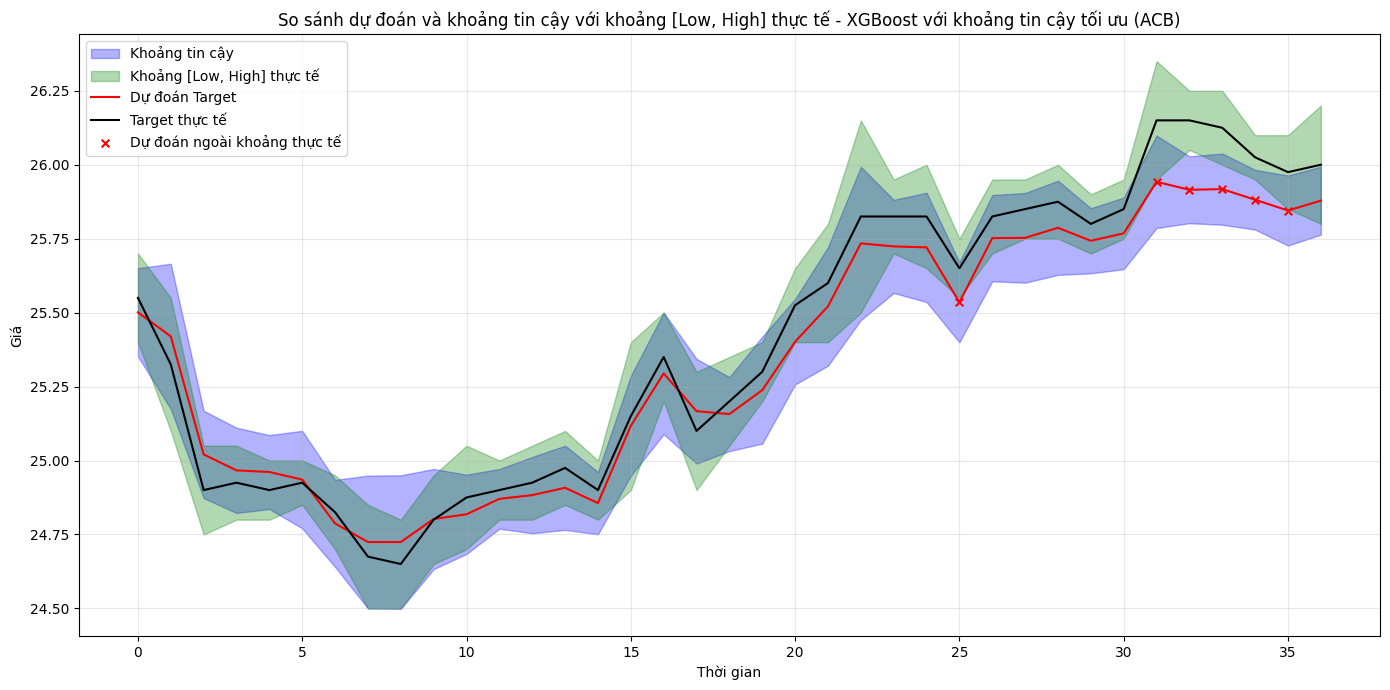

✓ ACB R² = 0.9580 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của BCM
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (396, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6733618039413735, 'gamma': 0.15212112147976886, 'learning_rate': 0.05485186100506259, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 660, 'reg_alpha': 0.5247746602583891, 'reg_lambda': 1.0997914575728833, 'subsample': 0.6186662652854461}
Best score: 0.4339 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6733618039413735, 'gamma': 0.1521211214797

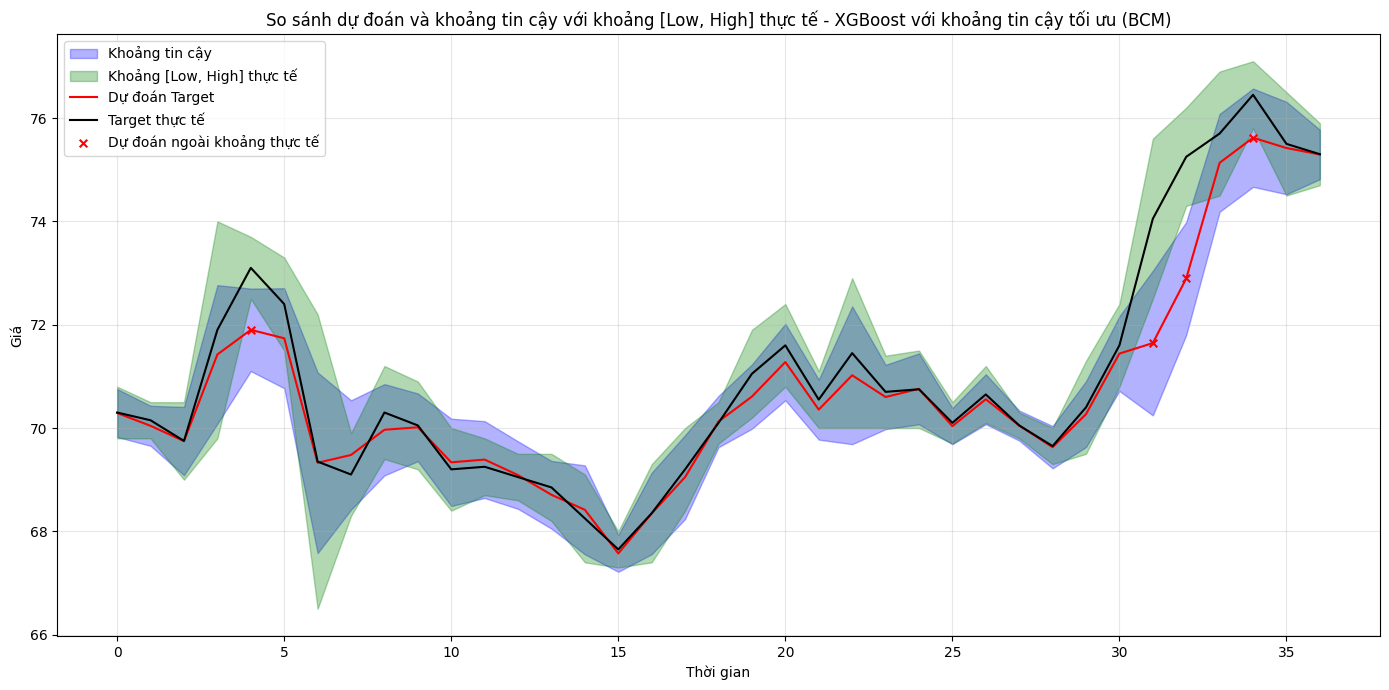

✓ BCM R² = 0.9168 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của BID
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (386, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6259568988435926, 'gamma': 0.12695770696717235, 'learning_rate': 0.028453225969667116, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 486, 'reg_alpha': 0.30087830981676966, 'reg_lambda': 0.9272607415662014, 'subsample': 0.6147547789418131}
Best score: 0.4362 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804

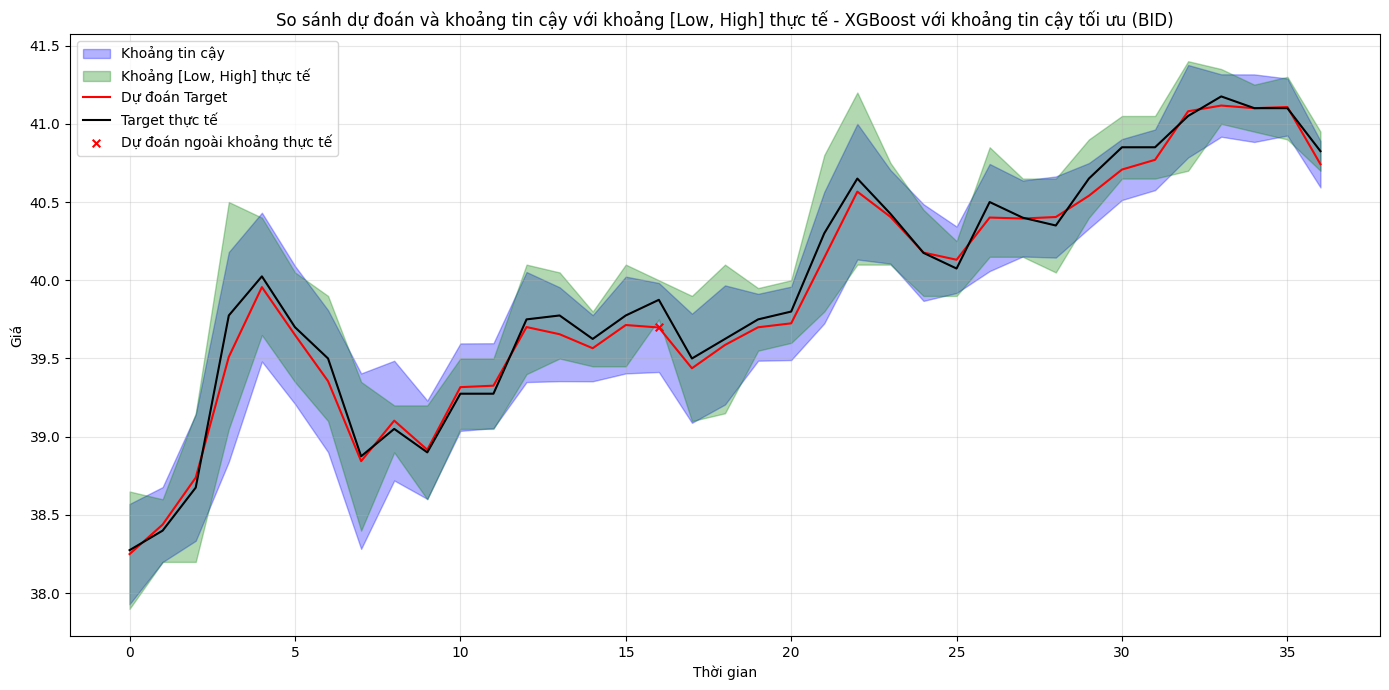

✓ BID R² = 0.9870 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của BVH
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (398, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6259568988435926, 'gamma': 0.12695770696717235, 'learning_rate': 0.028453225969667116, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 486, 'reg_alpha': 0.30087830981676966, 'reg_lambda': 0.9272607415662014, 'subsample': 0.6147547789418131}
Best score: 0.6320 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6259568988435926, 'gamma': 0.12695770696

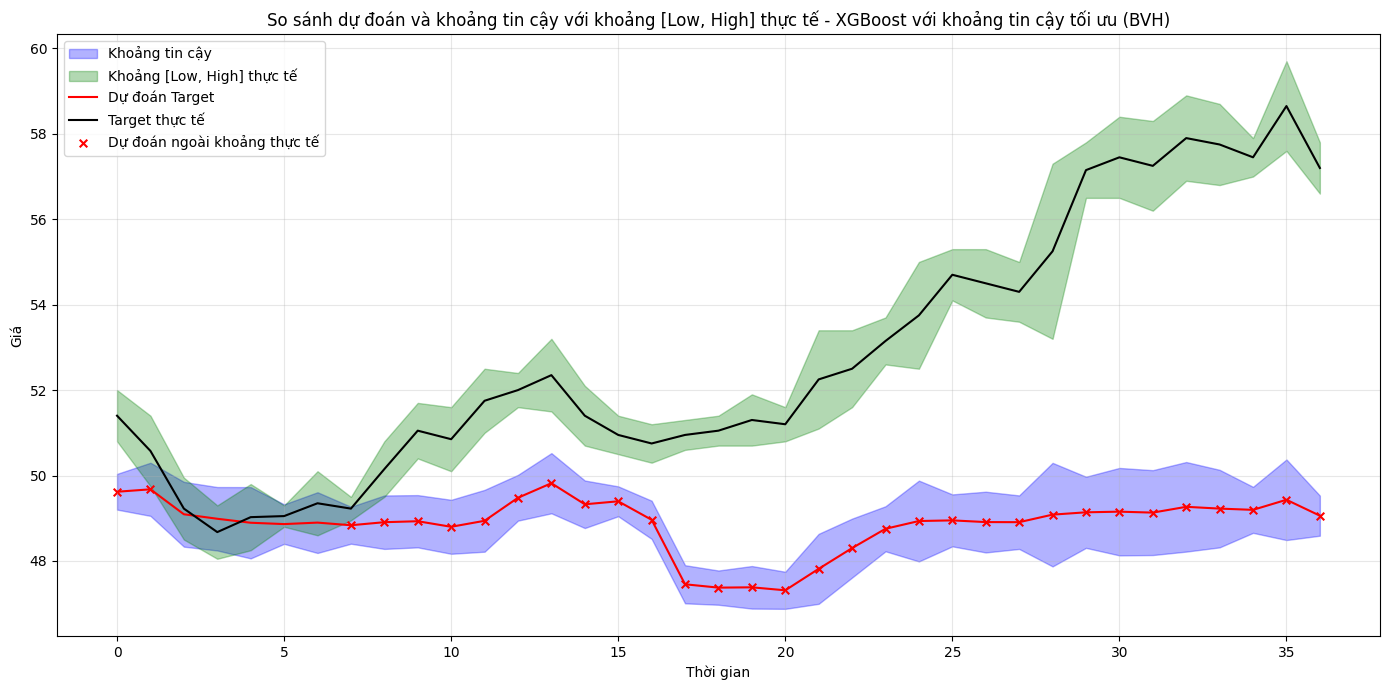

✗ BVH R² = -1.6723 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của CTG
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (393, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.9895022075365837, 'gamma': 0.11638567021515211, 'learning_rate': 0.013607611280617975, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 975, 'reg_alpha': 0.5142344384136116, 'reg_lambda': 1.3886218532930636, 'subsample': 0.6185801650879991}
Best score: 0.3336 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.9895022075365837, 'gamma': 0.116385

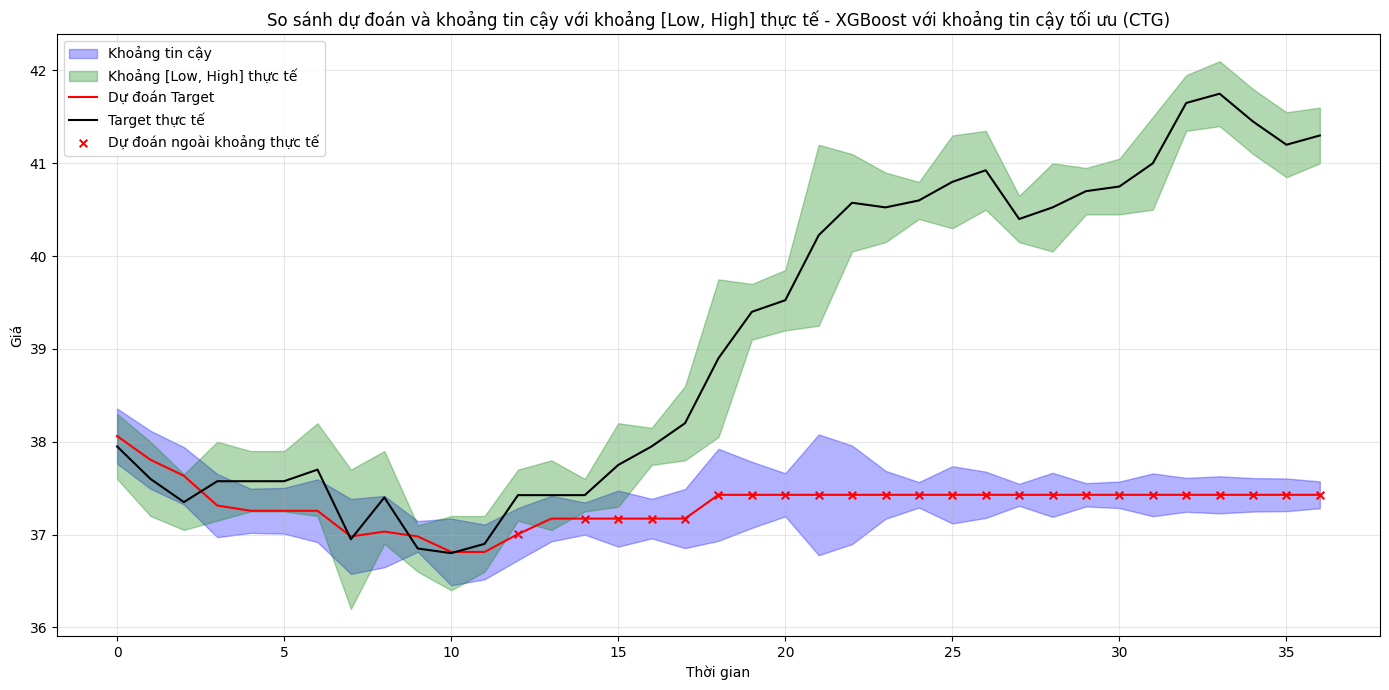

✗ CTG R² = -0.9777 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của FPT
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (374, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8675365010654429, 'gamma': 0.33296117830874833, 'learning_rate': 0.06117328983223407, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 646, 'reg_alpha': 0.4722149251619493, 'reg_lambda': 0.6793913689074526, 'subsample': 0.885297914889198}
Best score: 28.7309 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8675365010654429, 'gamma': 0.3329611

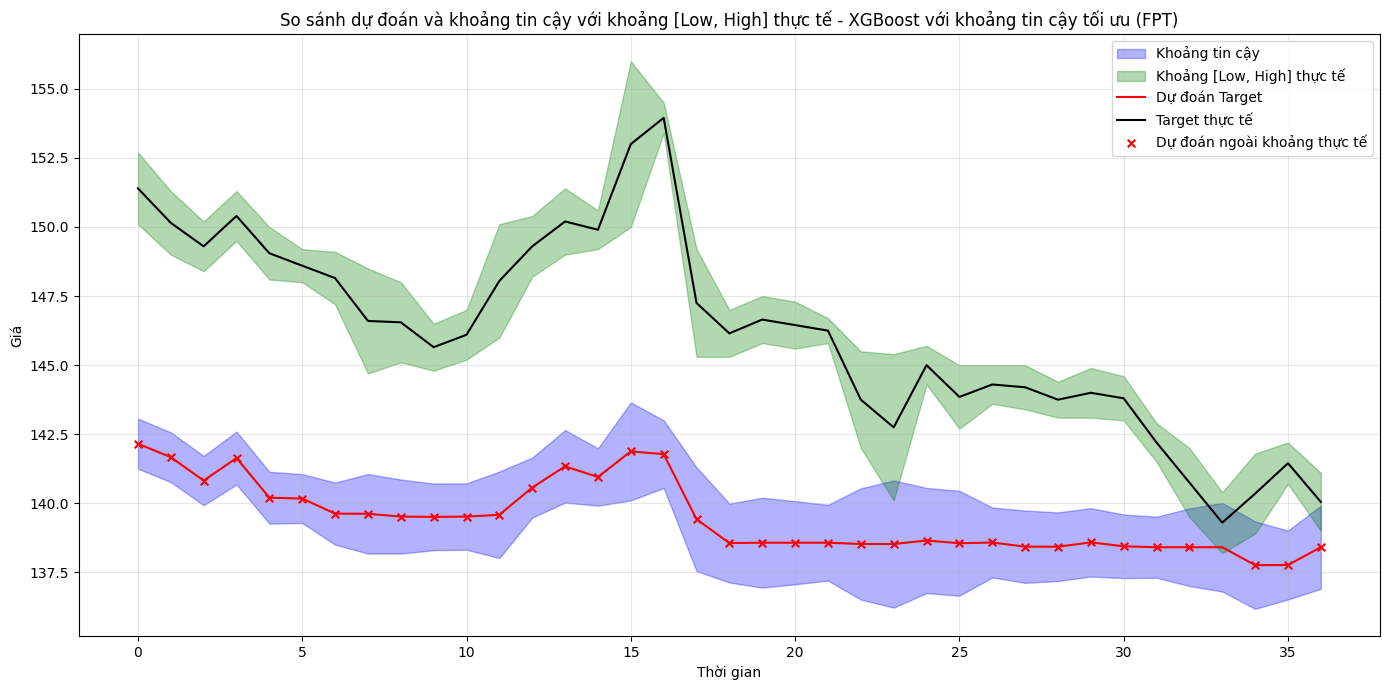

✗ FPT R² = -2.9948 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của GAS
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (396, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6923575302488596, 'gamma': 0.12051273301300586, 'learning_rate': 0.06991003428841853, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 875, 'reg_alpha': 0.034388521115218396, 'reg_lambda': 1.8639806031181732, 'subsample': 0.7035119926400067}
Best score: 2.8695 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585

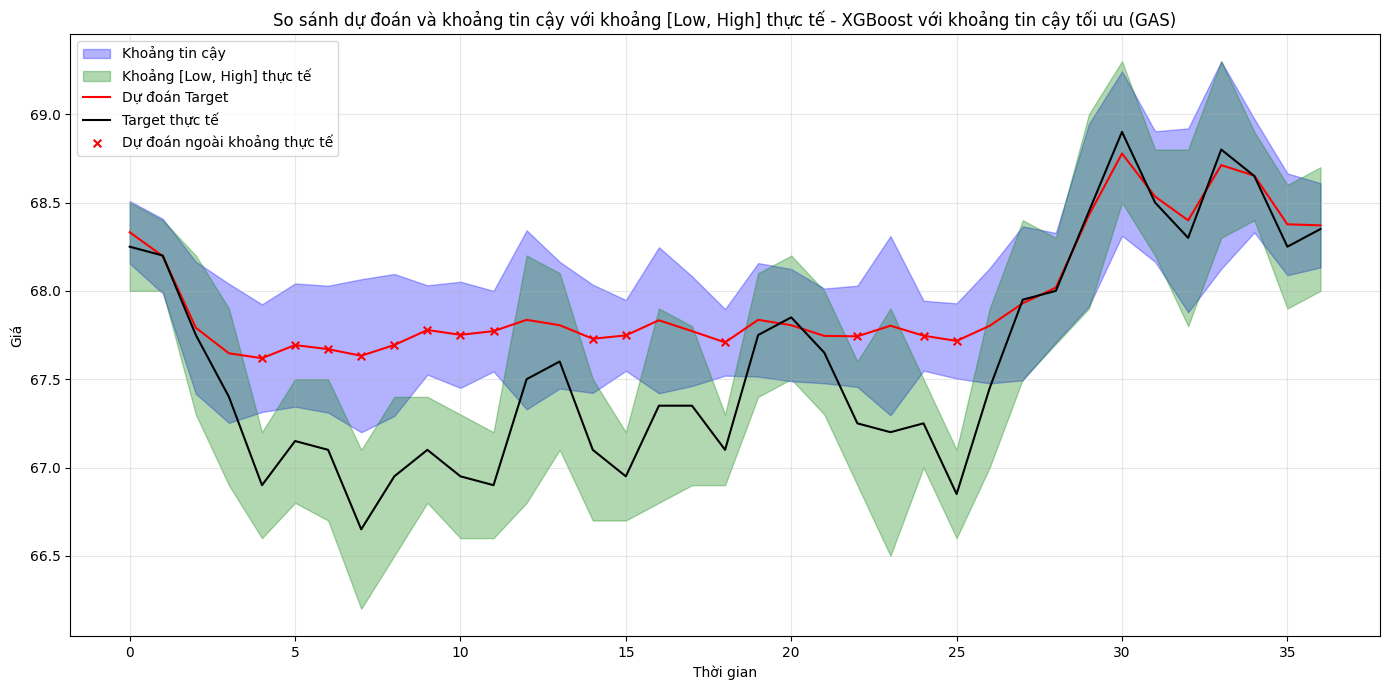

✗ GAS R² = 0.4002 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của GVR
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (382, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6296178606936361, 'gamma': 0.1792328642721363, 'learning_rate': 0.016007560654887322, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 939, 'reg_alpha': 0.4494506741382034, 'reg_lambda': 0.643115174735617, 'subsample': 0.7483273008793065}
Best score: 0.8610 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6296178606936361, 'gamma': 0.179232864

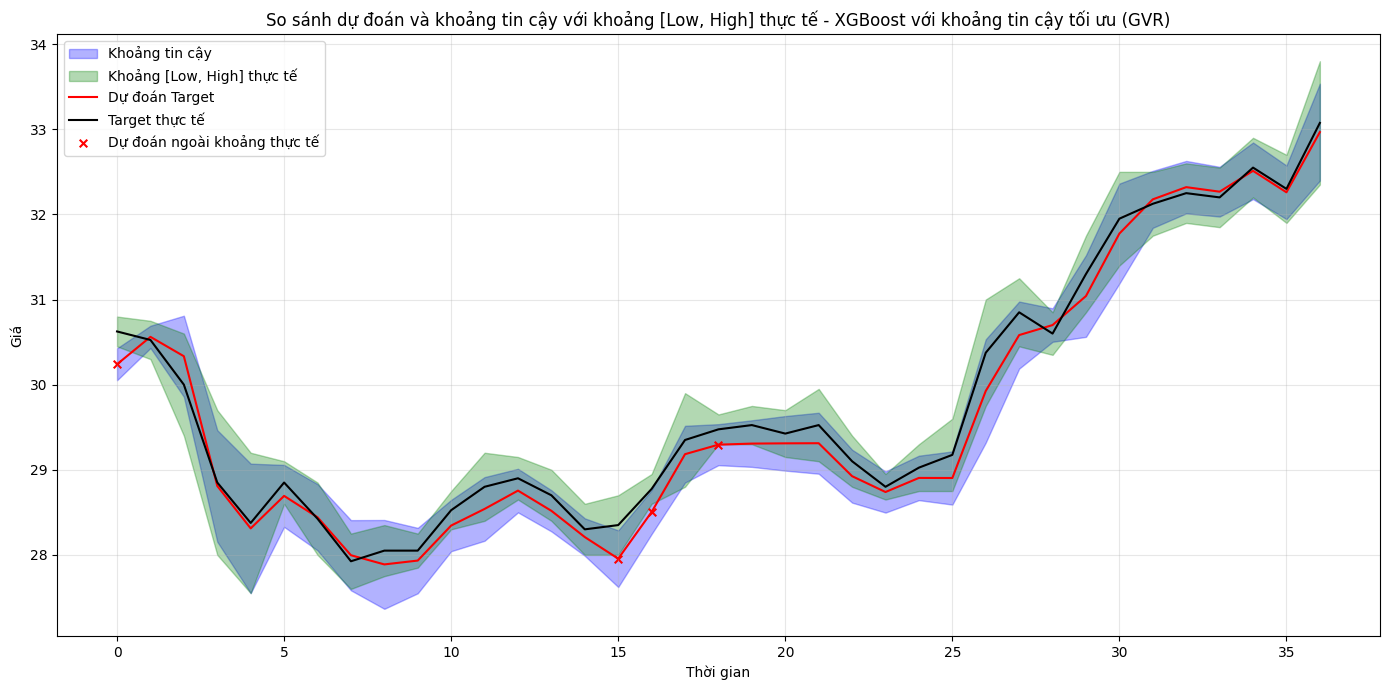

✓ GVR R² = 0.9823 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của HDB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (375, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6440207698110707, 'gamma': 0.11396758127097084, 'learning_rate': 0.045575239919494345, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 844, 'reg_alpha': 0.30478125815802903, 'reg_lambda': 0.7469837797144125, 'subsample': 0.8136357677501768}
Best score: 0.7645 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6296178606936361, 'gamma': 0.17923286427

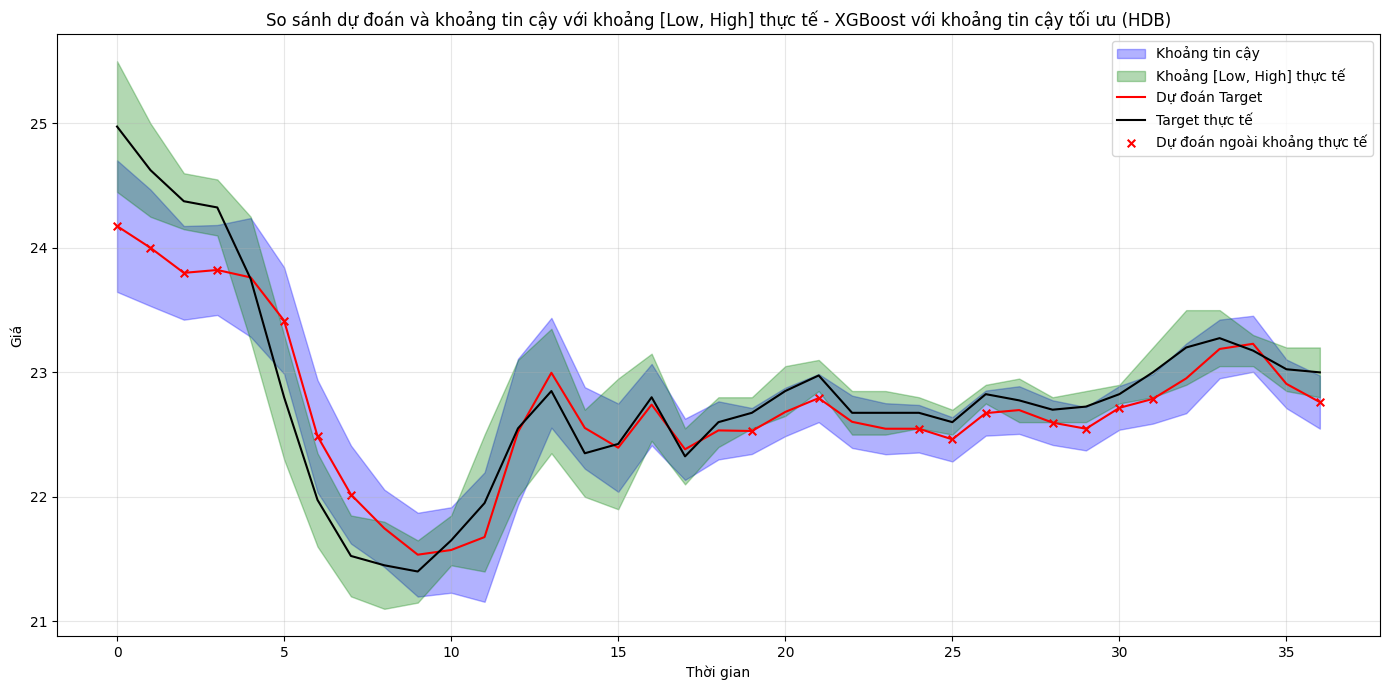

✓ HDB R² = 0.8643 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của HPG
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (390, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 0.0822 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.782613828193164, 'gamma': 0.109220218608

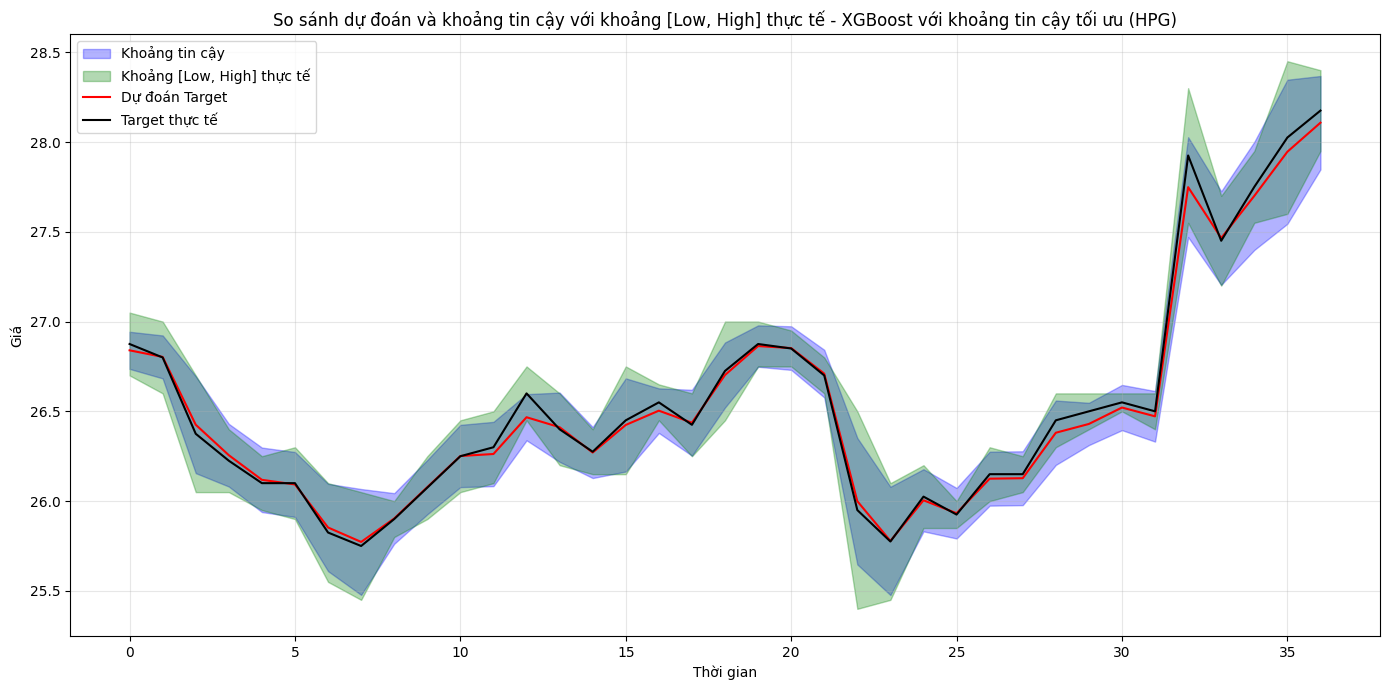

✓ HPG R² = 0.9936 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của LPB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (375, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 0.8047 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6259568988435926, 'gamma': 0.12695770696

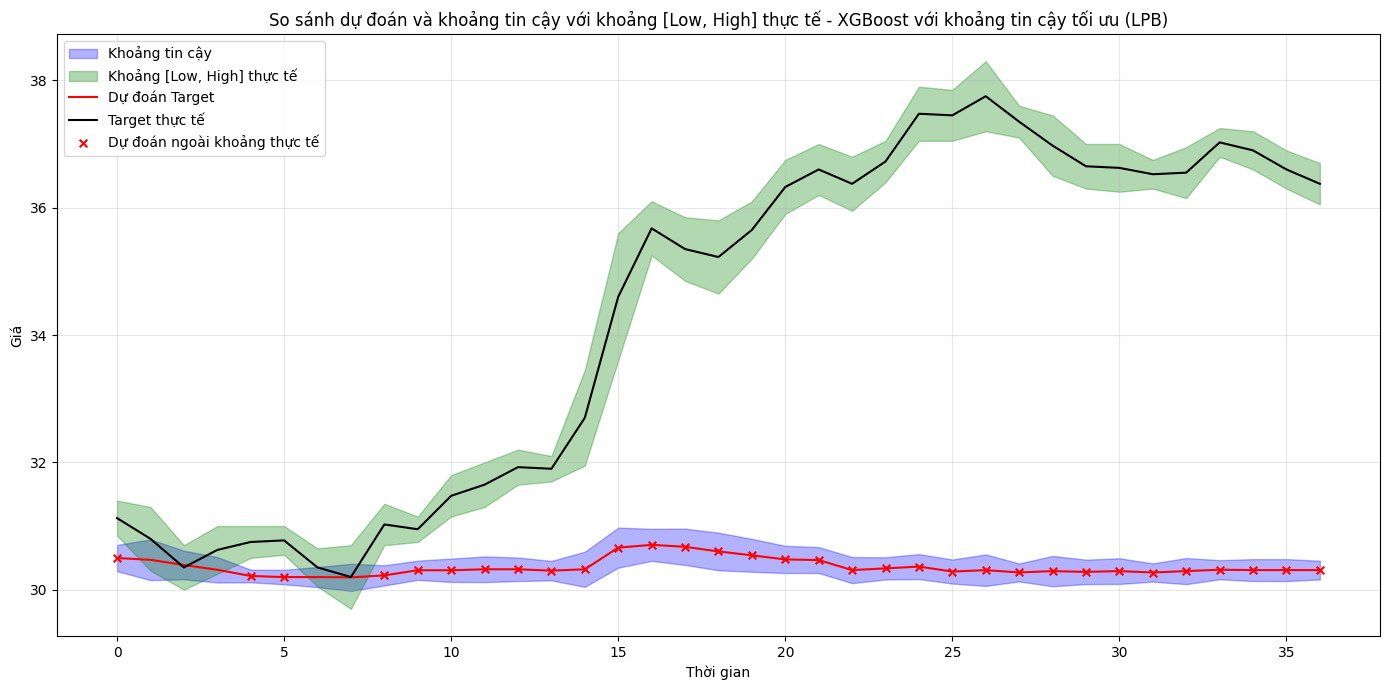

✗ LPB R² = -2.0592 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của MBB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (392, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6440207698110707, 'gamma': 0.11396758127097084, 'learning_rate': 0.045575239919494345, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 844, 'reg_alpha': 0.30478125815802903, 'reg_lambda': 0.7469837797144125, 'subsample': 0.8136357677501768}
Best score: 0.1587 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585

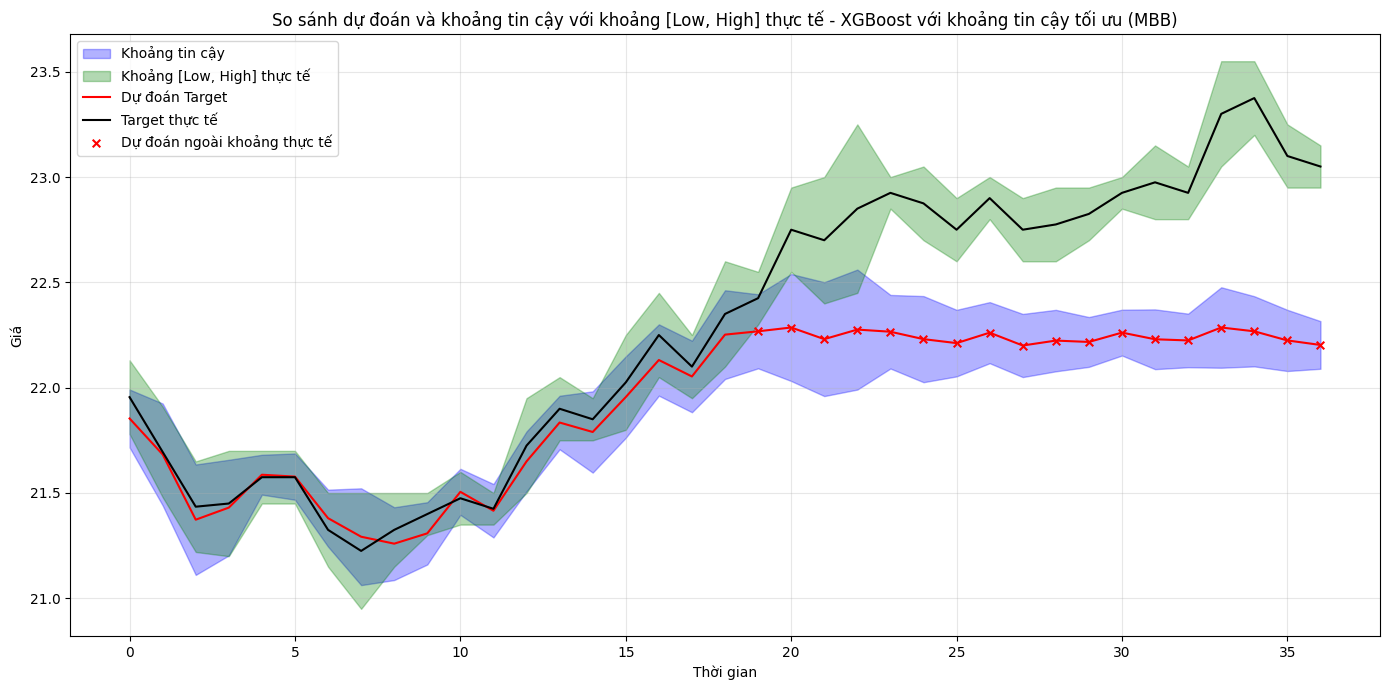

✗ MBB R² = 0.4736 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của MSN
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (394, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.9895022075365837, 'gamma': 0.11638567021515211, 'learning_rate': 0.013607611280617975, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 975, 'reg_alpha': 0.5142344384136116, 'reg_lambda': 1.3886218532930636, 'subsample': 0.6185801650879991}
Best score: 0.0598 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.9314950036607718, 'gamma': 0.1783766

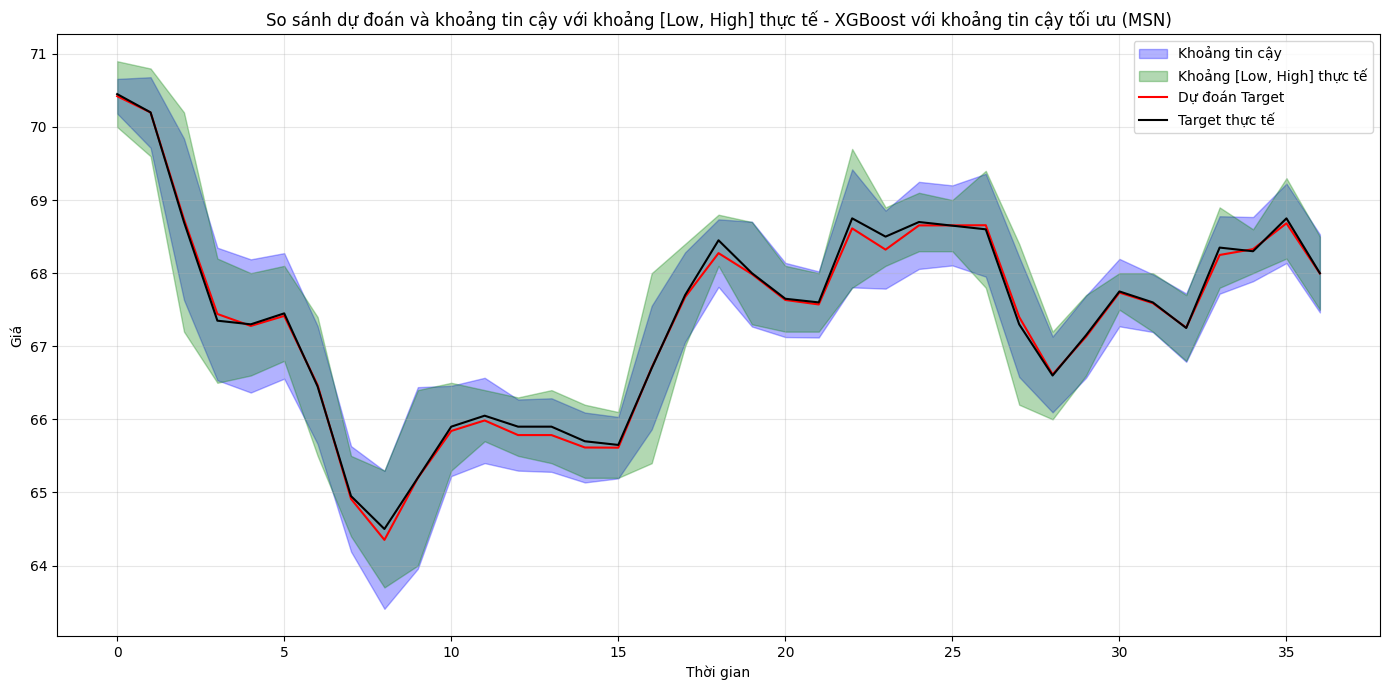

✓ MSN R² = 0.9971 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của MWG
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (381, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.7693605922825478, 'gamma': 0.19744075908778486, 'learning_rate': 0.03288137659821362, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 598, 'reg_alpha': 0.7068573438476171, 'reg_lambda': 1.5935107520614809, 'subsample': 0.9085081386743783}
Best score: 1.7211 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.1558555380447

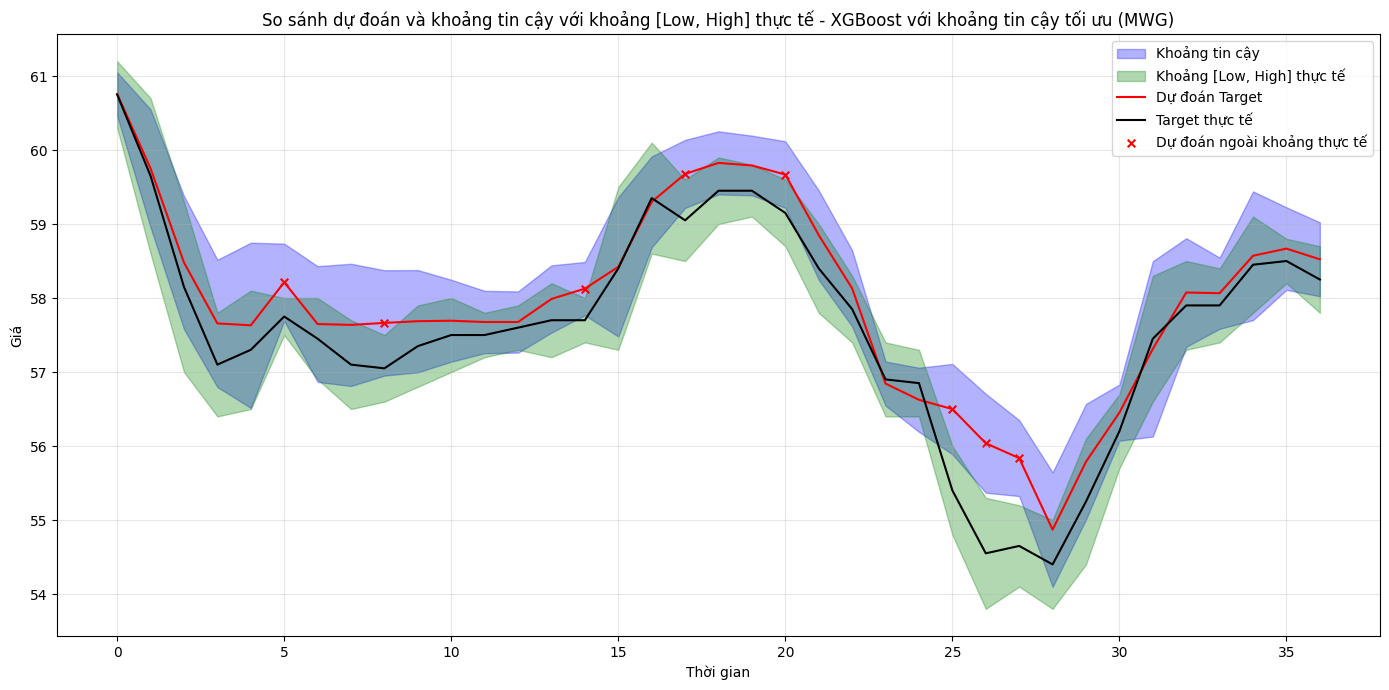

✓ MWG R² = 0.8831 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của PLX
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (392, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 0.1605 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8675365010654429, 'gamma': 0.33296117830

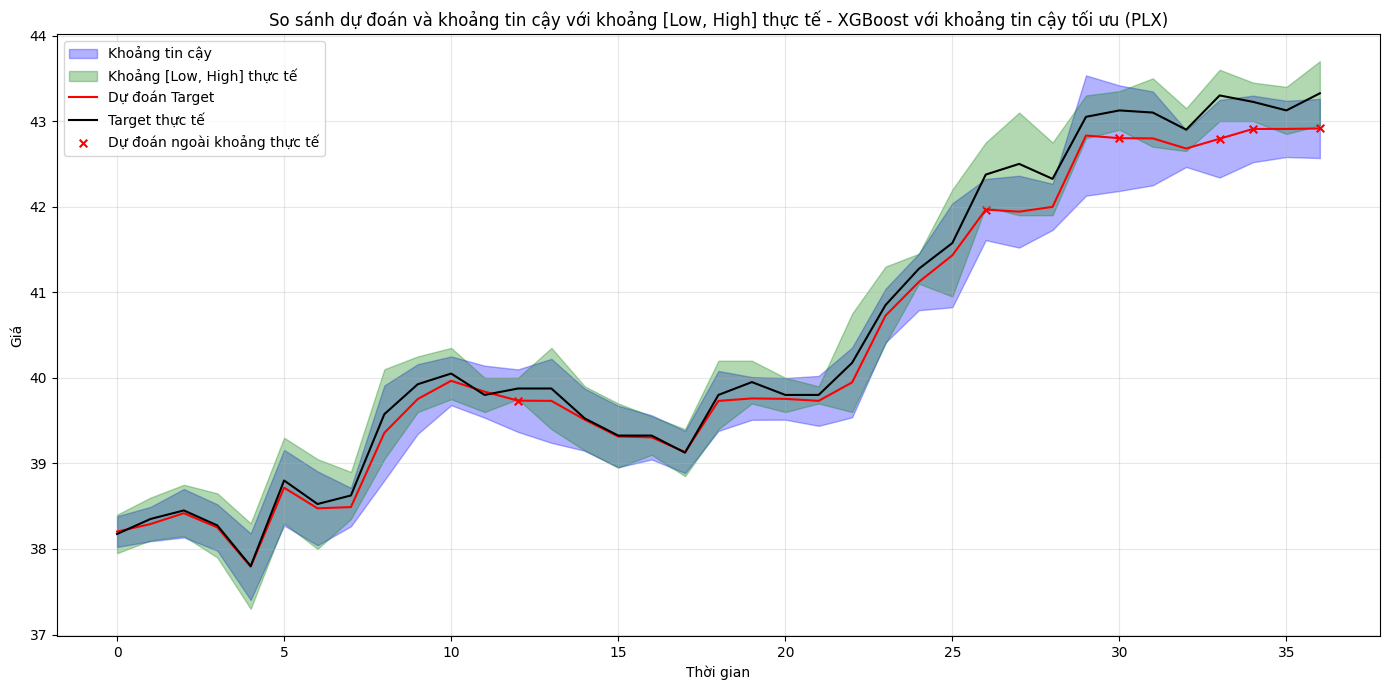

✓ PLX R² = 0.9847 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của SAB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (388, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8675365010654429, 'gamma': 0.33296117830874833, 'learning_rate': 0.06117328983223407, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 646, 'reg_alpha': 0.4722149251619493, 'reg_lambda': 0.6793913689074526, 'subsample': 0.885297914889198}
Best score: 0.7643 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470

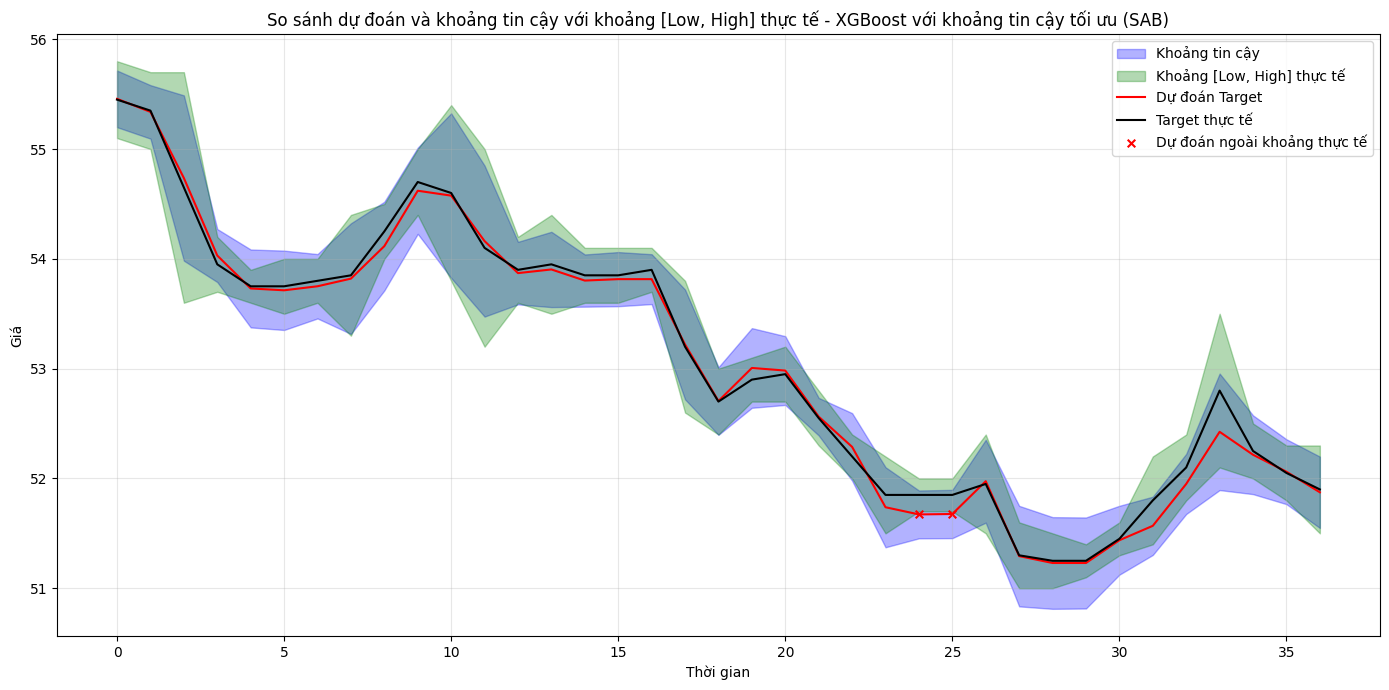

✓ SAB R² = 0.9928 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của SHB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (387, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.9043140194467589, 'gamma': 0.2806385987847481, 'learning_rate': 0.0782418820956833, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 492, 'reg_alpha': 0.7106628896857874, 'reg_lambda': 0.666336231217747, 'subsample': 0.7757346007463081}
Best score: 0.0053 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.9895022075365837, 'gamma': 0.1163856702151521

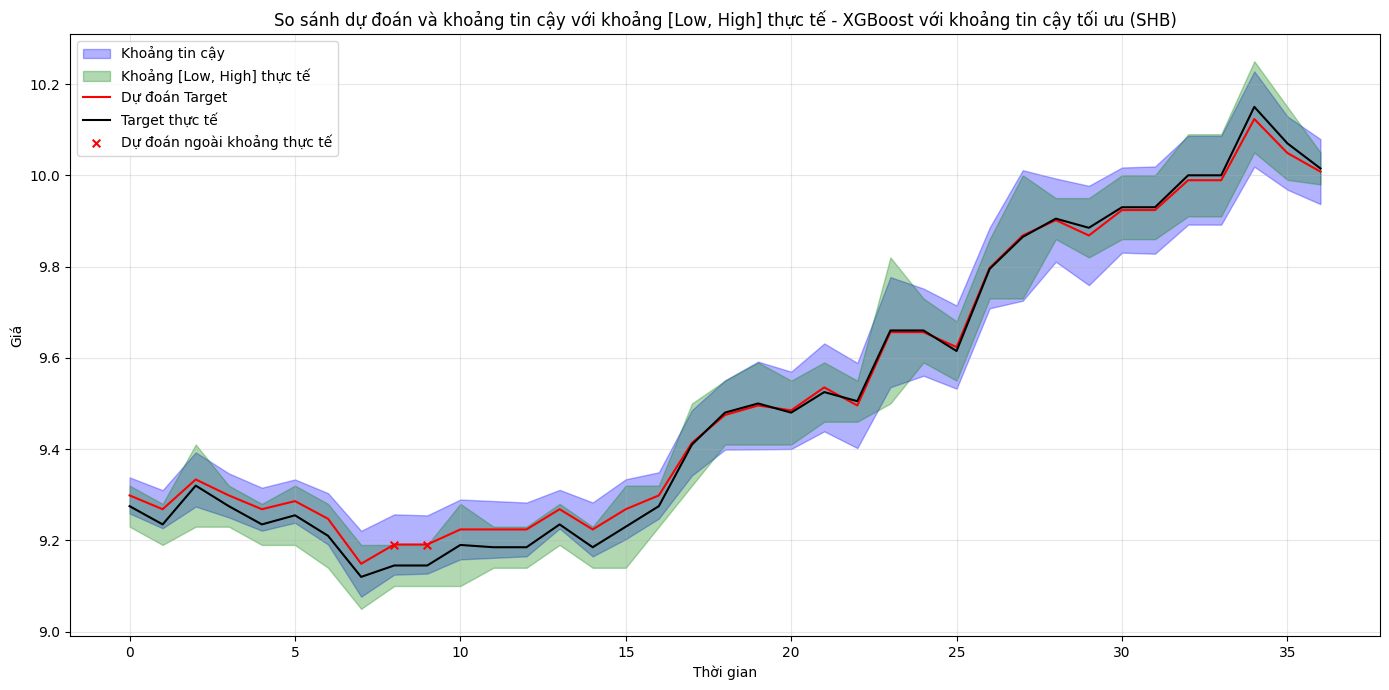

✓ SHB R² = 0.9943 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của SSB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (385, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 0.0888 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6259568988435926, 'gamma': 0.12695770696

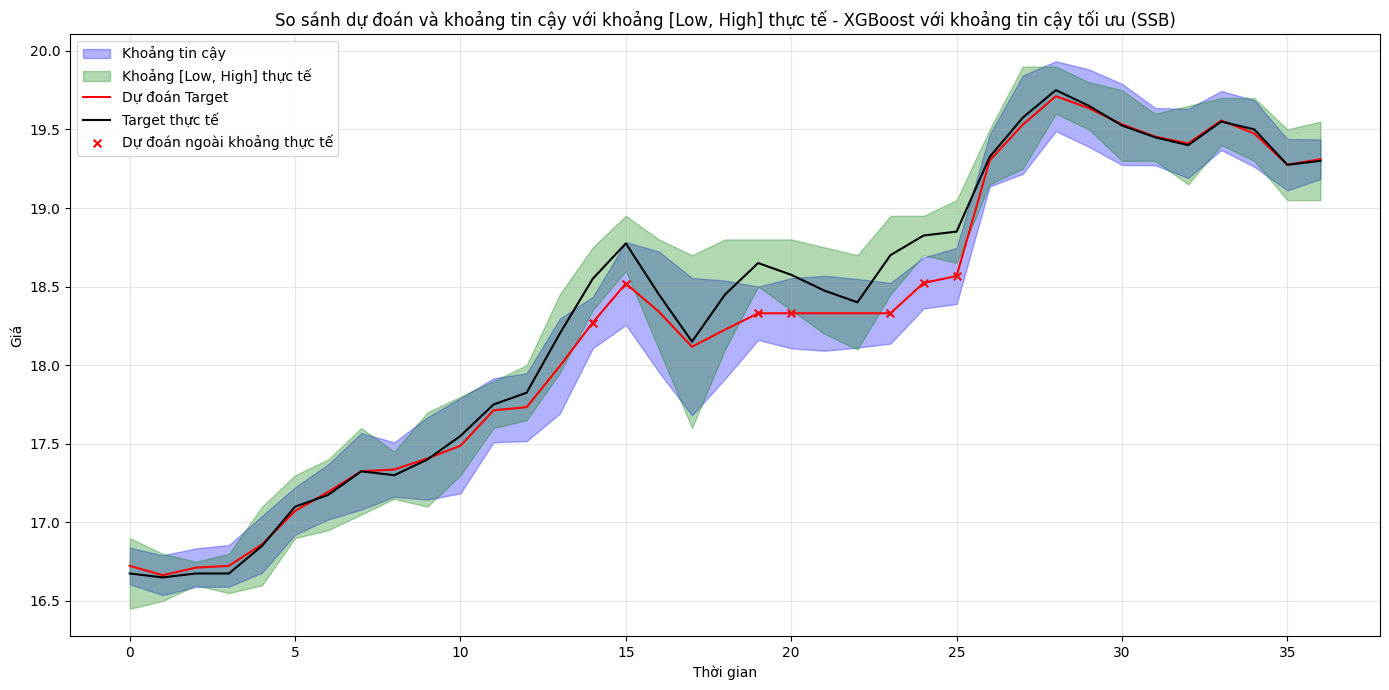

✓ SSB R² = 0.9787 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của SSI
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (395, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 2.0157 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804

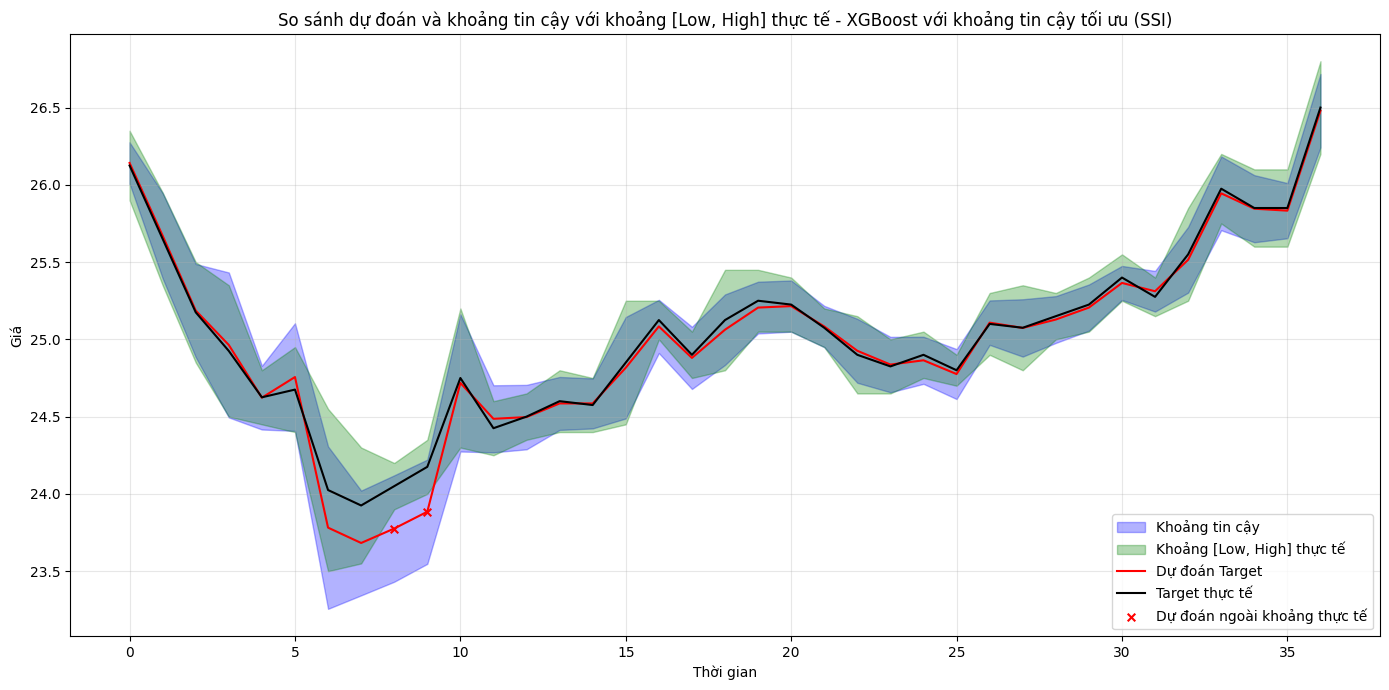

✓ SSI R² = 0.9745 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của STB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (378, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 0.2097 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804

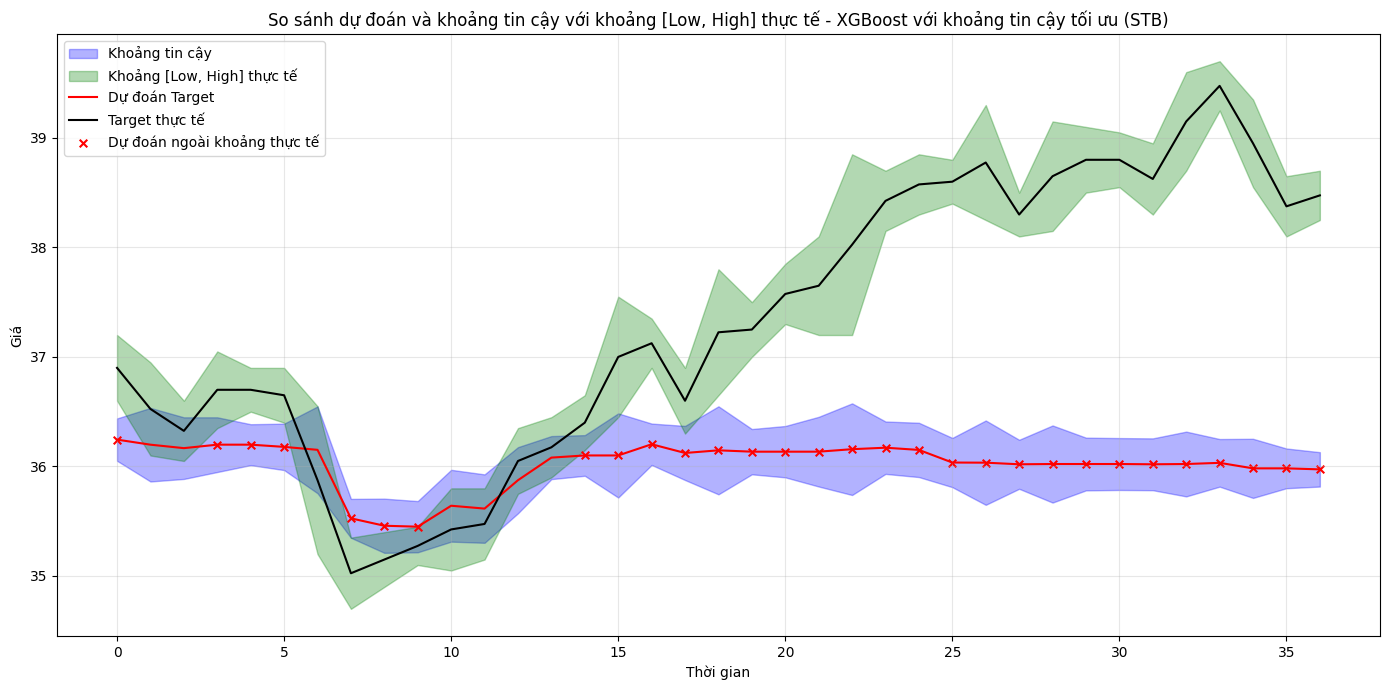

✗ STB R² = -0.9365 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của TCB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (371, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.6440207698110707, 'gamma': 0.11396758127097084, 'learning_rate': 0.045575239919494345, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 844, 'reg_alpha': 0.30478125815802903, 'reg_lambda': 0.7469837797144125, 'subsample': 0.8136357677501768}
Best score: 1.0082 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6440207698110707, 'gamma': 0.11396

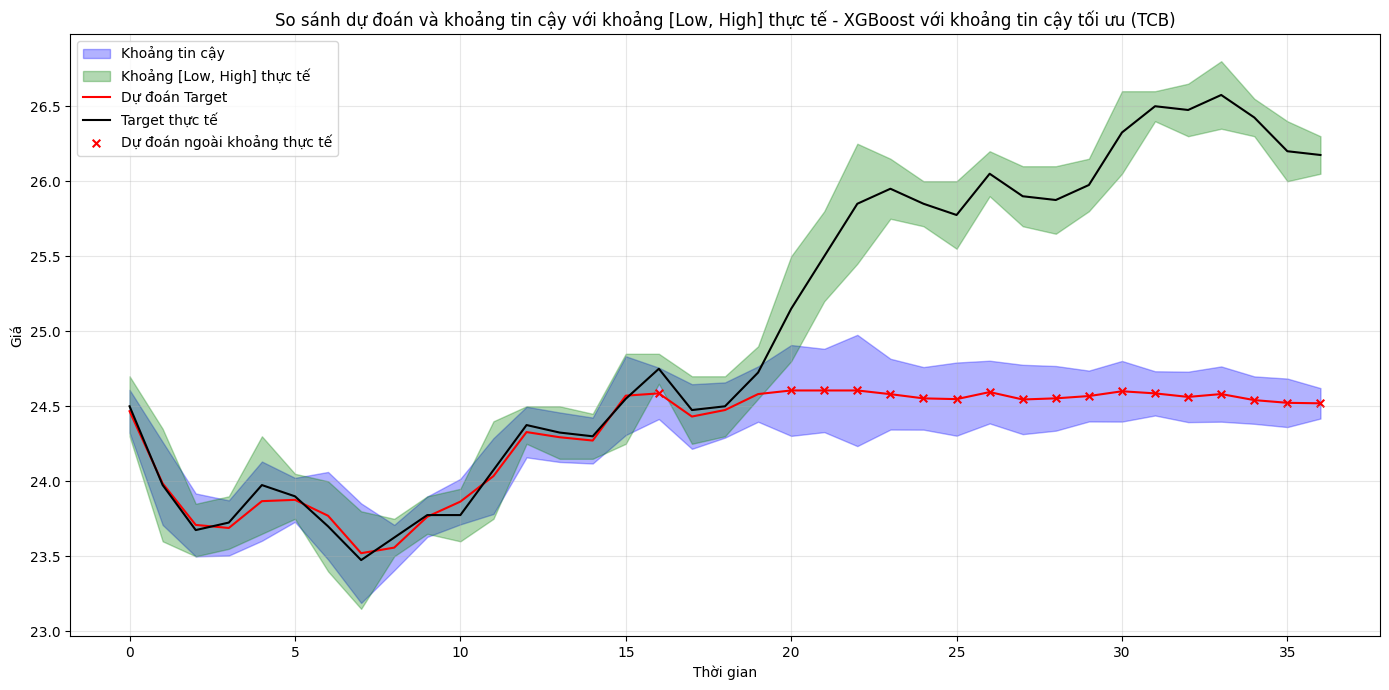

✗ TCB R² = 0.0107 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của TPB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (389, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 0.0244 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.155855

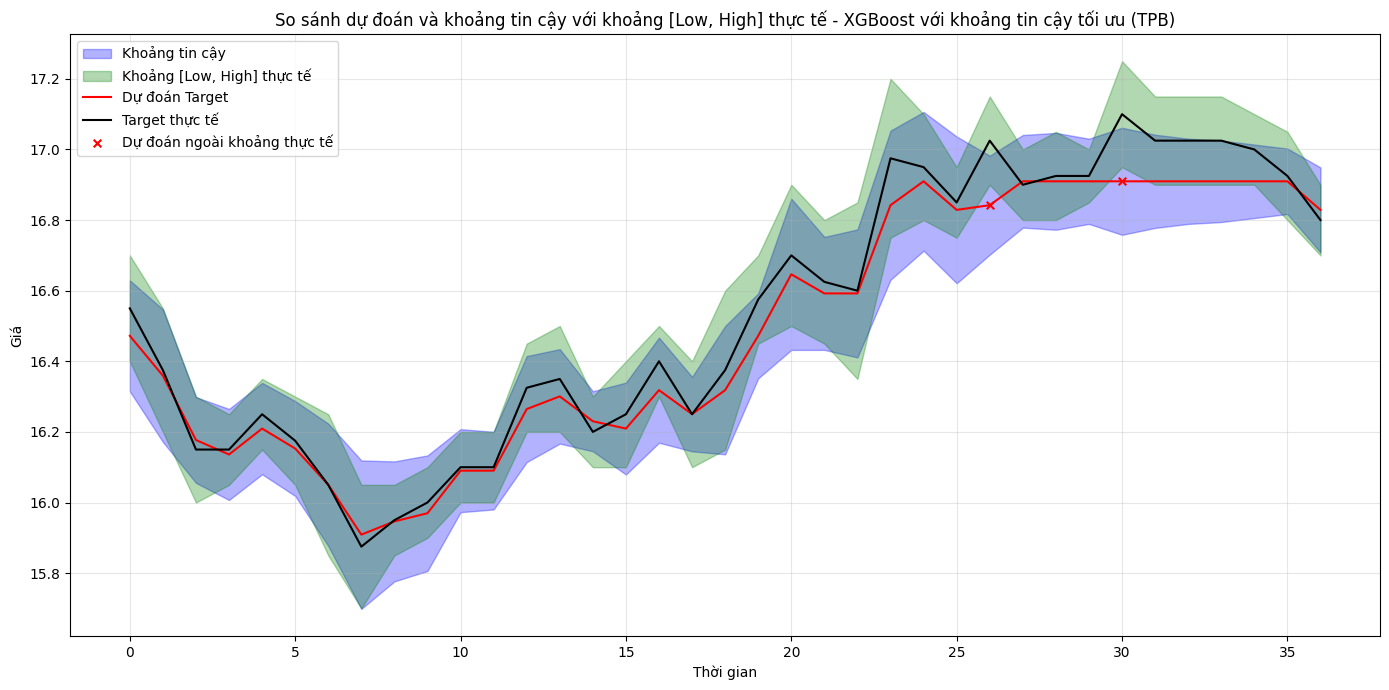

✓ TPB R² = 0.9652 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VCB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (385, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.7334834444556088, 'gamma': 0.07143340896097039, 'learning_rate': 0.06683440493014102, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 443, 'reg_alpha': 0.8324426408004217, 'reg_lambda': 0.8185086660174142, 'subsample': 0.6727299868828402}
Best score: 0.2244 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6259568988435926, 'gamma': 0.1269577069671

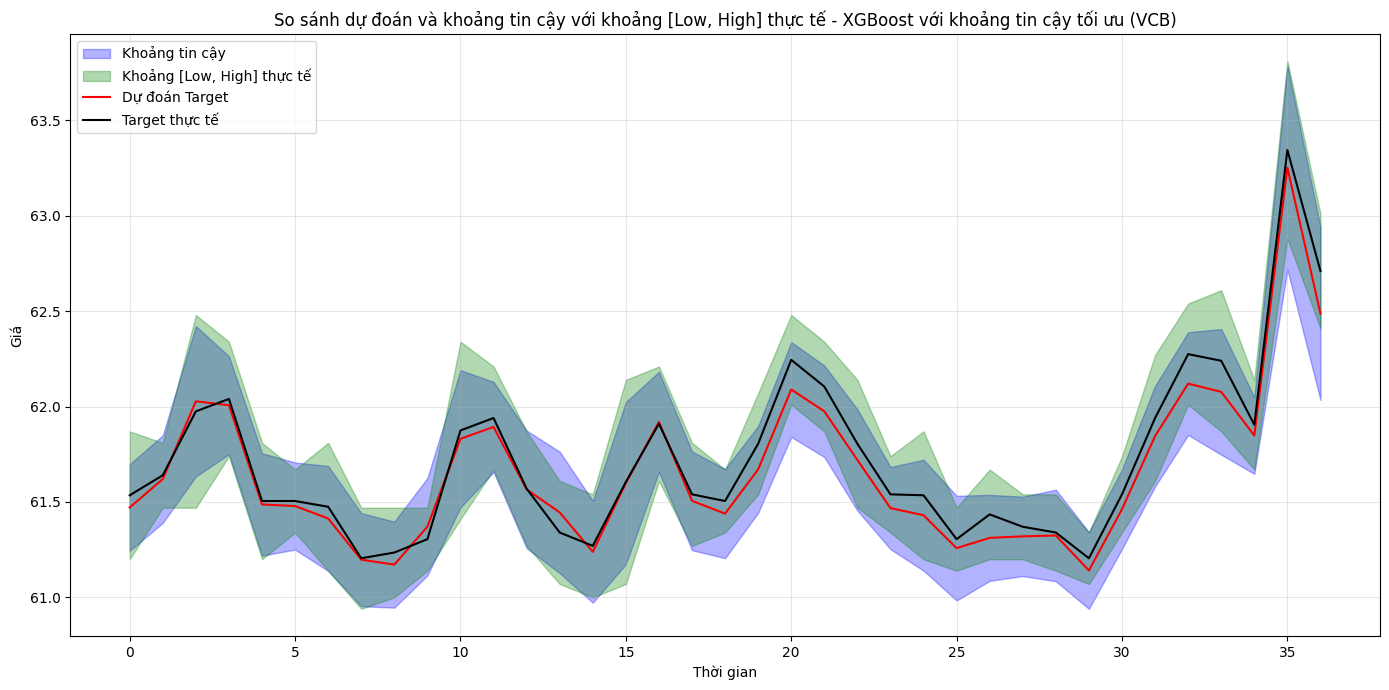

✓ VCB R² = 0.9616 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VHM
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (398, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.9043140194467589, 'gamma': 0.2806385987847481, 'learning_rate': 0.0782418820956833, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 492, 'reg_alpha': 0.7106628896857874, 'reg_lambda': 0.666336231217747, 'subsample': 0.7757346007463081}
Best score: 0.6476 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8438257335919588, 'gamma': 0.2513395116144307

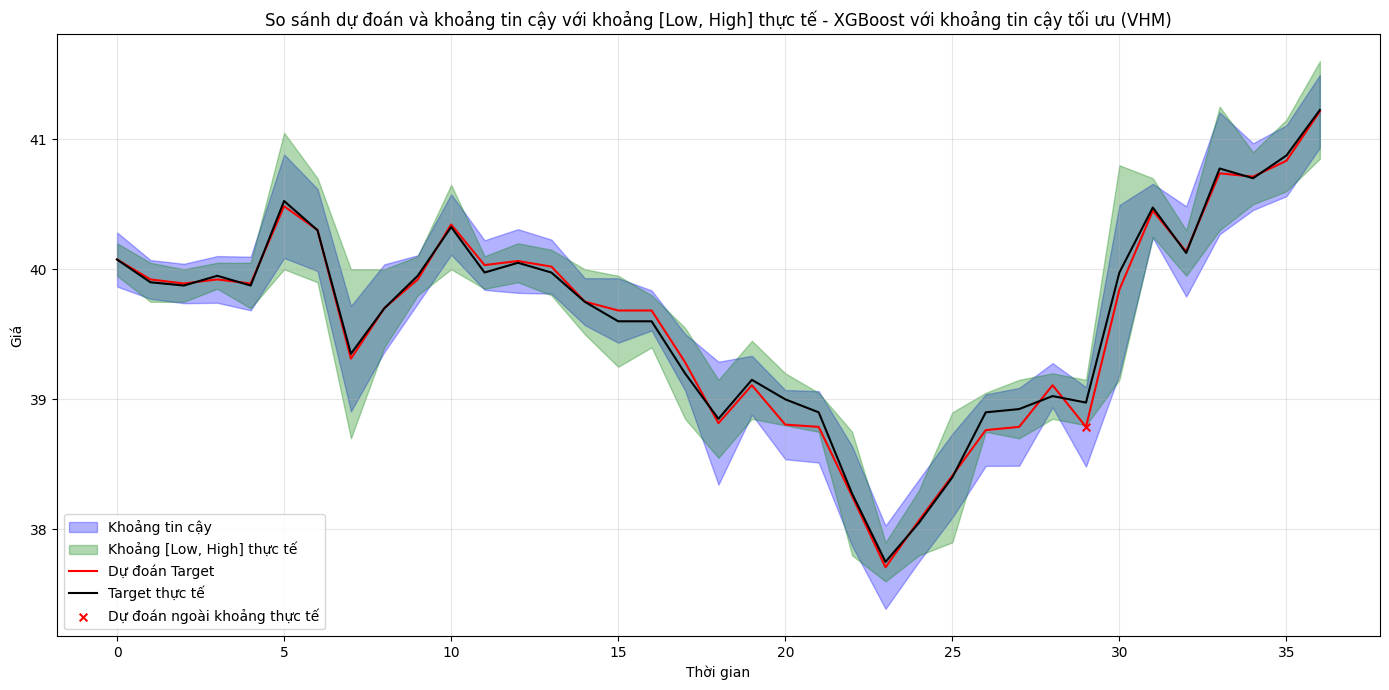

✓ VHM R² = 0.9920 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VIB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (389, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.9043140194467589, 'gamma': 0.2806385987847481, 'learning_rate': 0.0782418820956833, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 492, 'reg_alpha': 0.7106628896857874, 'reg_lambda': 0.666336231217747, 'subsample': 0.7757346007463081}
Best score: 0.0140 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.8675365010654429, 'gamma': 0.3329611783087483

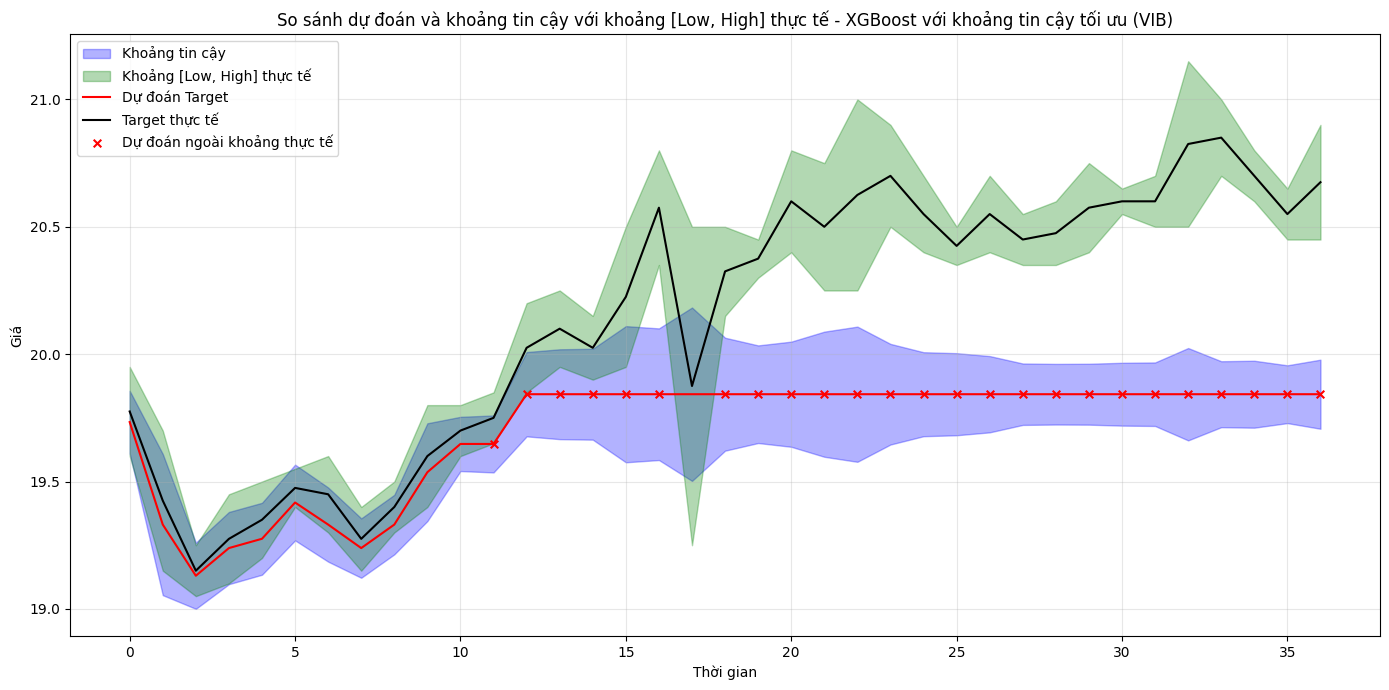

✗ VIB R² = -0.1326 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VIC
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (397, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.7939319885435933, 'gamma': 0.34621801644513517, 'learning_rate': 0.03059417171085954, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 473, 'reg_alpha': 0.21876421957307024, 'reg_lambda': 1.3371530030260117, 'subsample': 0.7615344684232164}
Best score: 1.0774 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.782613828193164, 'gamma': 0.1092202

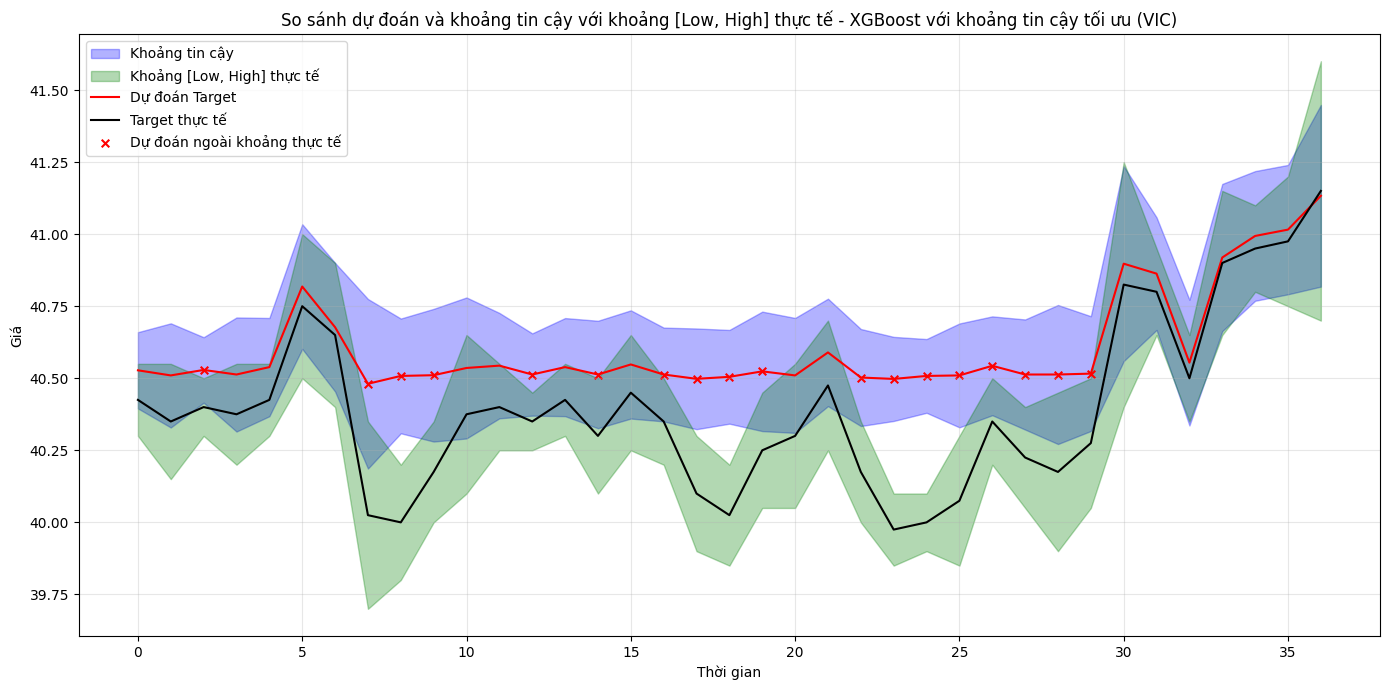

✗ VIC R² = 0.2256 - CHƯA ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VJC
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (395, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.9895022075365837, 'gamma': 0.11638567021515211, 'learning_rate': 0.013607611280617975, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 975, 'reg_alpha': 0.5142344384136116, 'reg_lambda': 1.3886218532930636, 'subsample': 0.6185801650879991}
Best score: 3.6310 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.9895022075365837, 'gamma': 0.1163856

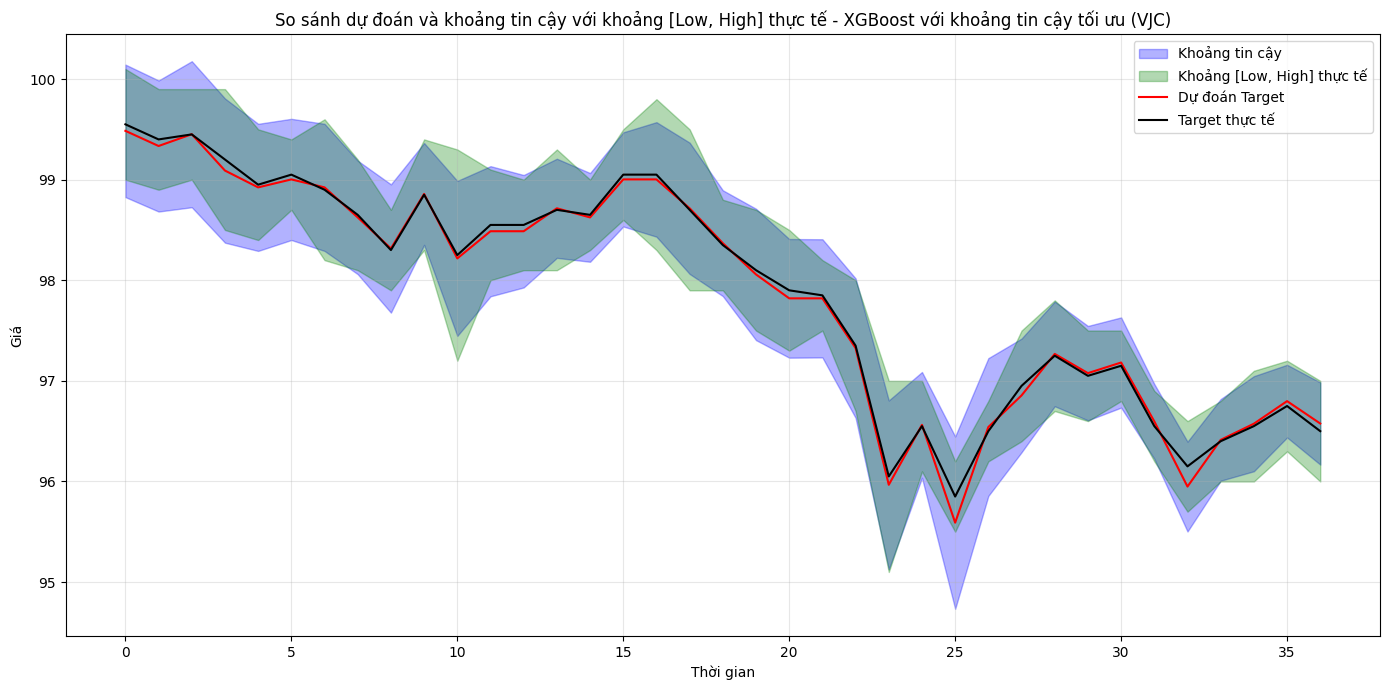

✓ VJC R² = 0.9959 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VNM
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (376, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.8650089137415928, 'gamma': 0.15585553804470548, 'learning_rate': 0.054406462011892025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 921, 'reg_alpha': 0.03131329245555858, 'reg_lambda': 1.7634271618924977, 'subsample': 0.7799016533479063}
Best score: 3.7428 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.6923575302488596, 'gamma': 0.12051273301

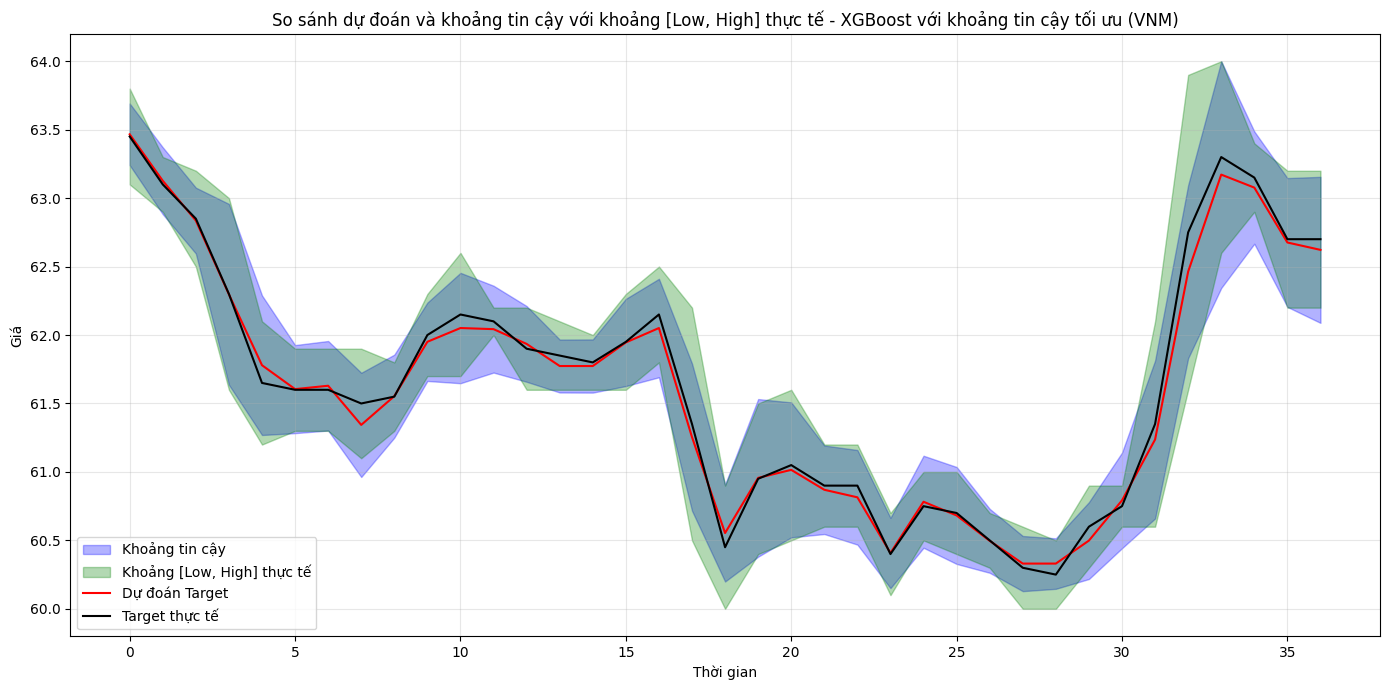

✓ VNM R² = 0.9918 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VPB
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (378, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.749816047538945, 'gamma': 0.4753571532049581, 'learning_rate': 0.07453942447208349, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 714, 'reg_alpha': 0.44583275285359114, 'reg_lambda': 0.6499623737270044, 'subsample': 0.7836995567863468}
Best score: 0.0858 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.7580600944007257, 'gamma': 0.46332943289689

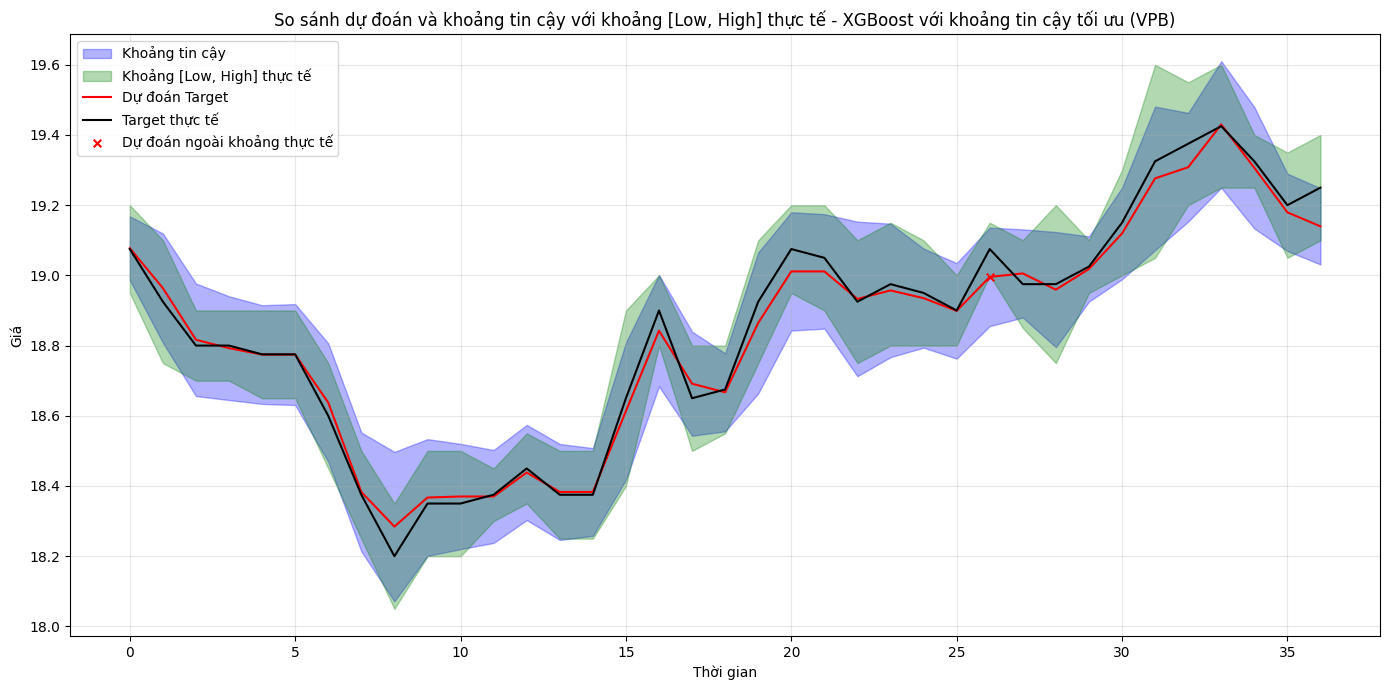

✓ VPB R² = 0.9857 - ĐẠT MỤC TIÊU

Đang xử lý dữ liệu của VRE
Kích thước dữ liệu train: 731 ngày, CV splits: 5, Số lần thử: 20
Chuẩn bị dữ liệu và tạo đặc trưng...
Kích thước tập train: (395, 132)
Kích thước tập test: (37, 132)
Số ngày trong df_test ban đầu: 59
Số ngày trong X_test sau xử lý: 37

Huấn luyện các mô hình...

===== Bắt đầu tìm kiếm hyperparameter tối ưu =====
Tìm kiếm hyperparameter tối ưu cho target...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for target: {'colsample_bytree': 0.782613828193164, 'gamma': 0.1092202186084168, 'learning_rate': 0.04456844504768479, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 739, 'reg_alpha': 0.8074401551640625, 'reg_lambda': 1.8441369498852398, 'subsample': 0.7272013899887455}
Best score: 0.1540 (MSE)
Tìm kiếm hyperparameter tối ưu cho high...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for high: {'colsample_bytree': 0.782613828193164, 'gamma': 0.1092202186084168

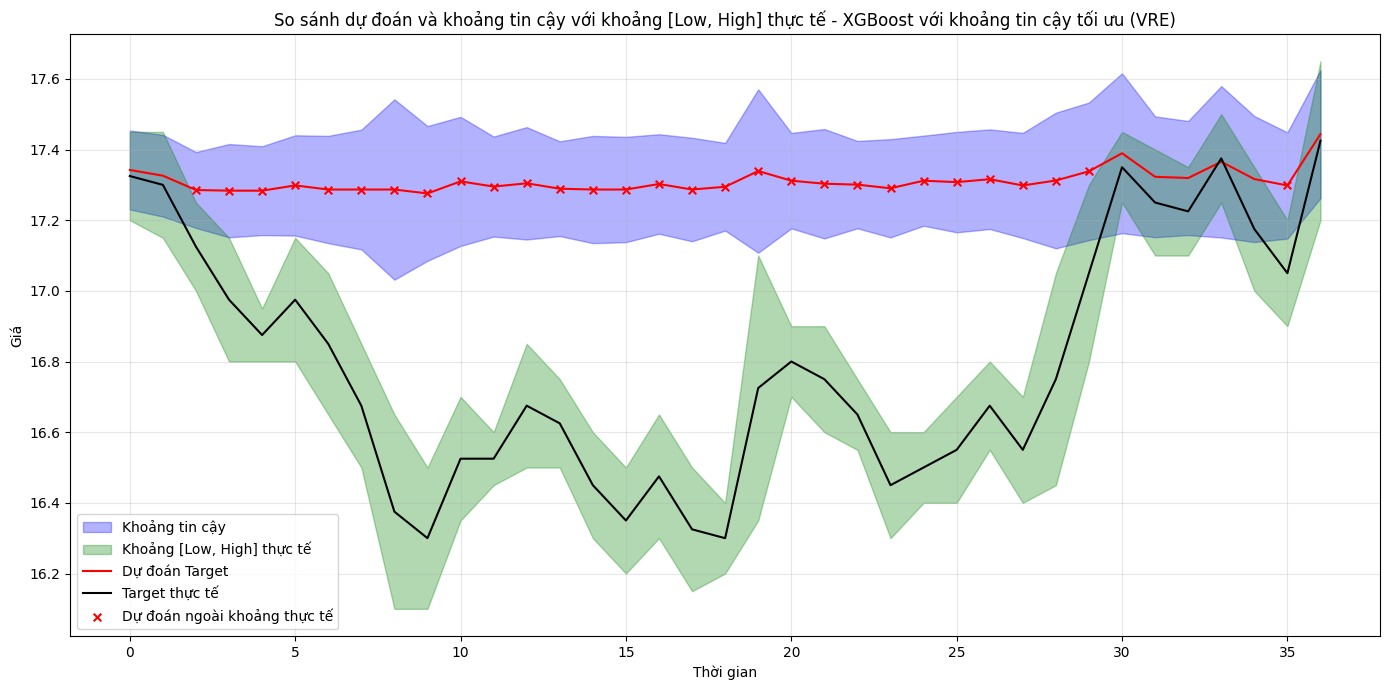

✗ VRE R² = -2.1903 - CHƯA ĐẠT MỤC TIÊU

Success rate: 19/30 (63.3%)


In [2]:
import warnings
warnings.filterwarnings('ignore')

vn30 = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

per_r2 = 0

# Tùy chọn tìm kiếm hyperparameter
tune_hyperparams = True  # Đặt thành True để bật tìm kiếm hyperparameter
n_cv_splits = 5  # Số lượng phân vùng CV theo thời gian
n_iter = 20  # Số lượng tổ hợp hyperparameter để thử

# Thiết lập hợp lý:
# - Dữ liệu ít (< 1000 ngày): n_iter = 20, n_cv_splits = 3
# - Dữ liệu nhiều (> 1000 ngày): n_iter = 50, n_cv_splits = 5

for symbol in vn30:
	print(f"\n{'='*50}")
	print(f"Đang xử lý dữ liệu của {symbol}")
	print(f"{'='*50}")
	
	df_train = pd.read_csv(f'../data/2023/vn30/{symbol}.csv')
	df_test = pd.read_csv(f'../data/2025/vn30/{symbol}.csv')

	# Đánh giá kích thước dữ liệu để điều chỉnh tham số CV phù hợp
	if len(df_train) < 500:
		current_n_cv = 3
		current_n_iter = 15
	else:
		current_n_cv = n_cv_splits
		current_n_iter = n_iter
		
	print(f"Kích thước dữ liệu train: {len(df_train)} ngày, CV splits: {current_n_cv}, Số lần thử: {current_n_iter}")

	# Chạy XGBoost với đầy đủ cải tiến trực tiếp từ dữ liệu gốc
	results = run_enhanced_prediction(
		df_train, df_test, 
		window_size=10, 
		symbol=symbol,
		tune_hyperparams=tune_hyperparams,
		n_cv_splits=current_n_cv,
		n_iter=current_n_iter
	)
	
	r2 = results['metrics']['final']['r2']
	if r2 > 0.75:
		per_r2 += 1
		print(f"✓ {symbol} R² = {r2:.4f} - ĐẠT MỤC TIÊU")
	else:
		print(f"✗ {symbol} R² = {r2:.4f} - CHƯA ĐẠT MỤC TIÊU")

print(f"\nSuccess rate: {per_r2}/{len(vn30)} ({per_r2/len(vn30)*100:.1f}%)")